# Classification Benchmarking

**The goal of this notebook is to benchmark different algorithms on the classification of the toy dataset, before moving to the next stage that is using them for our real data on the autistic project.**


The algorithms that will be tested are:

* The baseline algorithm is the use of `imputations` techniques (let's say MICE, or Matias' technic) both at training and for the inference.

    
* Imputation using Matias' `custom_imputations` method, that resorts on pdf estimation with kernel. The model is a k dimensional distribution, estimating using a gaussian kernel with optimal bandwidth, handling missing coordinates by imputing them based on the proximity with other data from the training set. The inference for a sample is performed on the subset of coordinates that are known, by computing first the marginal of the k-dimensional distribution on the known axis. Note here that no imputation are performed at inference time, but there are during training. 
        
* The `no_imputations` approach will be used, which consist in estimating several distributions, $f_{X|Z}$, and doing inference using them. No imputation are performed, and the marginals are not used (yet). 
    
* The use of `neural_additive_models` developed in [1] will be tested. This method present an interpretable way of using neural network in this setting.
    
* The use of `XGBoost` will be tested. 



Also, direct use of the $Z$ distributions will be used for classification, usinf 

<ins>Inputs:</ins>

* $(X_n)_n \in \mathbb{R}^K$


* $(Z_n)_n \in [ 0, 1]^K $


<ins>Outputs:</ins>

* $(Y_n)_n \in [ 0, 1]$

We would like to show:

* Do a benchmarking of the different methods. 
* If encoding the Nans, is it necessary to add the Z variables ?
* SEE TABLE and come up with experiments. 


    
    
<ins>Takeaways:</ins>

    * Handling missing data is better than discarding them.
    * ...

[1]. Agarwal, R. et al. Neural Additive Models: Interpretable Machine Learning with Neural Nets. Arxiv (2020).

In [9]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


In [10]:
df = create_df()

In [11]:
df

,dataset_name,experiment_number,approach,missing_data_handling,imputation_method,use_missing_indicator_variables,num_samples,imbalance_ratio,missingness_pattern,missingness_mechanism,ratio_of_missing_values,missing_X1,missing_X2,missing_first_quarter,ratio_missing_per_class_0,ratio_missing_per_class_1,auc,Accuracy,F1,MCC,Sensitivity,Specificity,Precision,PPV,NPV,FNR,FDR,FOR,resolution,bandwidth,estimation_time_0,estimation_time_1
0,moons,61,multi_distributions,without,without,None,8000,0.25,4,MNAR,None,True,True,False,0,0.94125,NaN,0.4140,0.4480,0.2590,1.0000,0.2310,0.2890,0.2890,1.0000,0.0000,0.7110,0.0000,30,0.2,NaN,NaN
1,moons,59,multi_distributions,without,without,None,8000,0.25,3,MAR,0.2,True,False,True,None,None,NaN,0.2990,0.0980,-0.4310,0.1550,0.3460,0.0720,0.0720,0.5560,0.8450,0.9280,0.4440,30,0.2,NaN,NaN
2,moons,50,multi_distributions,without,without,None,8000,0.25,1,MCAR,0.1,True,False,None,None,None,NaN,0.2890,0.1340,-0.4150,0.2140,0.3150,0.0970,0.0970,0.5370,0.7860,0.9030,0.4630,30,0.2,NaN,NaN
3,moons,57,multi_distributions,without,without,None,8000,0.25,3,MAR,0,True,False,True,None,None,NaN,0.1520,0.0900,-0.6420,0.1640,0.1480,0.0620,0.0620,0.3400,0.8360,0.9380,0.6600,30,0.2,NaN,NaN
4,moons,32,multi_distributions,without,without,None,8000,0.25,5,MNAR,None,True,True,True,0,0.0785,NaN,0.2480,0.2100,-0.3750,0.4070,0.1960,0.1420,0.1420,0.5040,0.5930,0.8580,0.4960,30,0.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,blobs,22,nam,encoding,without,True,8000,0.10,5,MNAR,None,True,True,True,0,0.476875,1.0000,0.9992,0.9967,0.9962,0.9933,1.0000,1.0000,1.0000,0.9992,0.0067,0.0000,0.0008,30,0.2,NaN,NaN
443,blobs,149,multi_distributions,without,without,None,8000,0.50,3,MAR,0.2,True,False,True,None,None,NaN,0.4940,0.4520,-0.0050,0.4030,0.5920,0.5140,0.5140,0.4810,0.5970,0.4860,0.5190,30,0.2,NaN,NaN
444,blobs,171,single_distribution,imputation,mean,None,8000,0.10,2,MAR,0,True,True,True,None,None,NaN,0.6760,0.1560,0.0120,0.3020,0.7170,0.1050,0.1050,0.9030,0.6980,0.8950,0.0970,30,0.2,NaN,NaN
445,blobs,185,nam,encoding,without,True,8000,0.25,3,MAR,0.1,True,False,True,None,None,0.9949,0.9744,0.9467,0.9322,0.8995,0.9998,0.9994,0.9994,0.9672,0.1005,0.0006,0.0328,30,0.2,NaN,NaN


In [6]:
df.replace({None:np.nan}, inplace=True)
df.query(" `num_samples` >= @NUM_SAMPLES")

,dataset_name,experiment_number,approach,missing_data_handling,imputation_method,use_missing_indicator_variables,num_samples,imbalance_ratio,missingness_pattern,missingness_mechanism,ratio_of_missing_values,missing_X1,missing_X2,missing_first_quarter,ratio_missing_per_class_0,ratio_missing_per_class_1,auc,Accuracy,F1,MCC,Sensitivity,Specificity,Precision,PPV,NPV,FNR,FDR,FOR,resolution,bandwidth,estimation_time_0,estimation_time_1
0,circles,20,multi_distributions,without,without,NaN,8000,0.25,1,MCAR,0.3,True,False,NaN,NaN,NaN,NaN,0.675,0.505,0.289,0.628,0.692,0.422,0.422,0.838,0.372,0.578,0.162,30,0.2,NaN,NaN
1,circles,18,multi_distributions,without,without,NaN,8000,0.25,1,MCAR,0.1,True,False,NaN,NaN,NaN,NaN,0.698,0.517,0.315,0.618,0.727,0.445,0.445,0.843,0.382,0.555,0.157,30,0.2,NaN,NaN
2,circles,9,multi_distributions,without,without,NaN,8000,0.10,3,MAR,0.0,True,False,True,NaN,NaN,NaN,0.716,0.279,0.189,0.553,0.734,0.187,0.187,0.937,0.447,0.813,0.063,30,0.2,NaN,NaN
3,circles,11,multi_distributions,without,without,NaN,8000,0.10,3,MAR,0.2,True,False,True,NaN,NaN,NaN,0.677,0.258,0.177,0.604,0.684,0.164,0.164,0.944,0.396,0.836,0.056,30,0.2,NaN,NaN
4,circles,7,multi_distributions,without,without,NaN,8000,0.10,2,MAR,0.2,True,True,True,NaN,NaN,NaN,0.581,0.215,0.095,0.575,0.582,0.133,0.133,0.925,0.425,0.867,0.075,30,0.2,NaN,NaN
5,circles,16,multi_distributions,without,without,NaN,8000,0.10,5,MNAR,NaN,True,True,True,0.000000,0.232500,NaN,0.485,0.161,-0.003,0.513,0.482,0.095,0.095,0.903,0.487,0.905,0.097,30,0.2,NaN,NaN
6,circles,6,multi_distributions,without,without,NaN,8000,0.10,2,MAR,0.1,True,True,True,NaN,NaN,NaN,0.581,0.213,0.086,0.558,0.583,0.132,0.132,0.921,0.442,0.868,0.079,30,0.2,NaN,NaN
7,circles,17,multi_distributions,without,without,NaN,8000,0.25,1,MCAR,0.0,True,False,NaN,NaN,NaN,NaN,0.719,0.496,0.313,0.582,0.761,0.432,0.432,0.854,0.418,0.568,0.146,30,0.2,NaN,NaN
8,circles,1,multi_distributions,without,without,NaN,8000,0.10,1,MCAR,0.0,True,False,NaN,NaN,NaN,NaN,0.716,0.279,0.189,0.553,0.734,0.187,0.187,0.937,0.447,0.813,0.063,30,0.2,NaN,NaN
9,circles,10,multi_distributions,without,without,NaN,8000,0.10,3,MAR,0.1,True,False,True,NaN,NaN,NaN,0.598,0.189,0.080,0.536,0.603,0.115,0.115,0.931,0.464,0.885,0.069,30,0.2,NaN,NaN


# Introduction - Dataset definition

In [8]:
# Dataset default parameters
dataset_name = DATASET_NAME
num_samples = NUM_SAMPLES
imbalance_ratio = IMBALANCE_RATIO

# Missingness default parameters
missingness_pattern = MISSINGNESS_PATTERN
ratio_of_missing_values = RATIO_OF_MISSING_VALUES
ratio_missing_per_class = RATIO_MISSING_PER_CLASS
# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH

# Classification default parameters
proportion_train = PROPORTION_TRAIN
missing_data_handling = MISSING_DATA_HANDLING
imputation_method = DEFAULT_IMPUTATION_METHOD

# VERBOSITY
verbosity=4

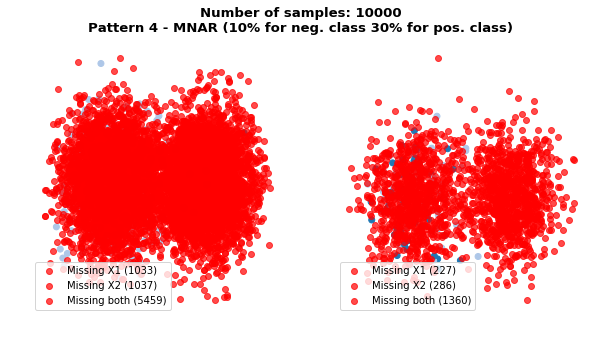

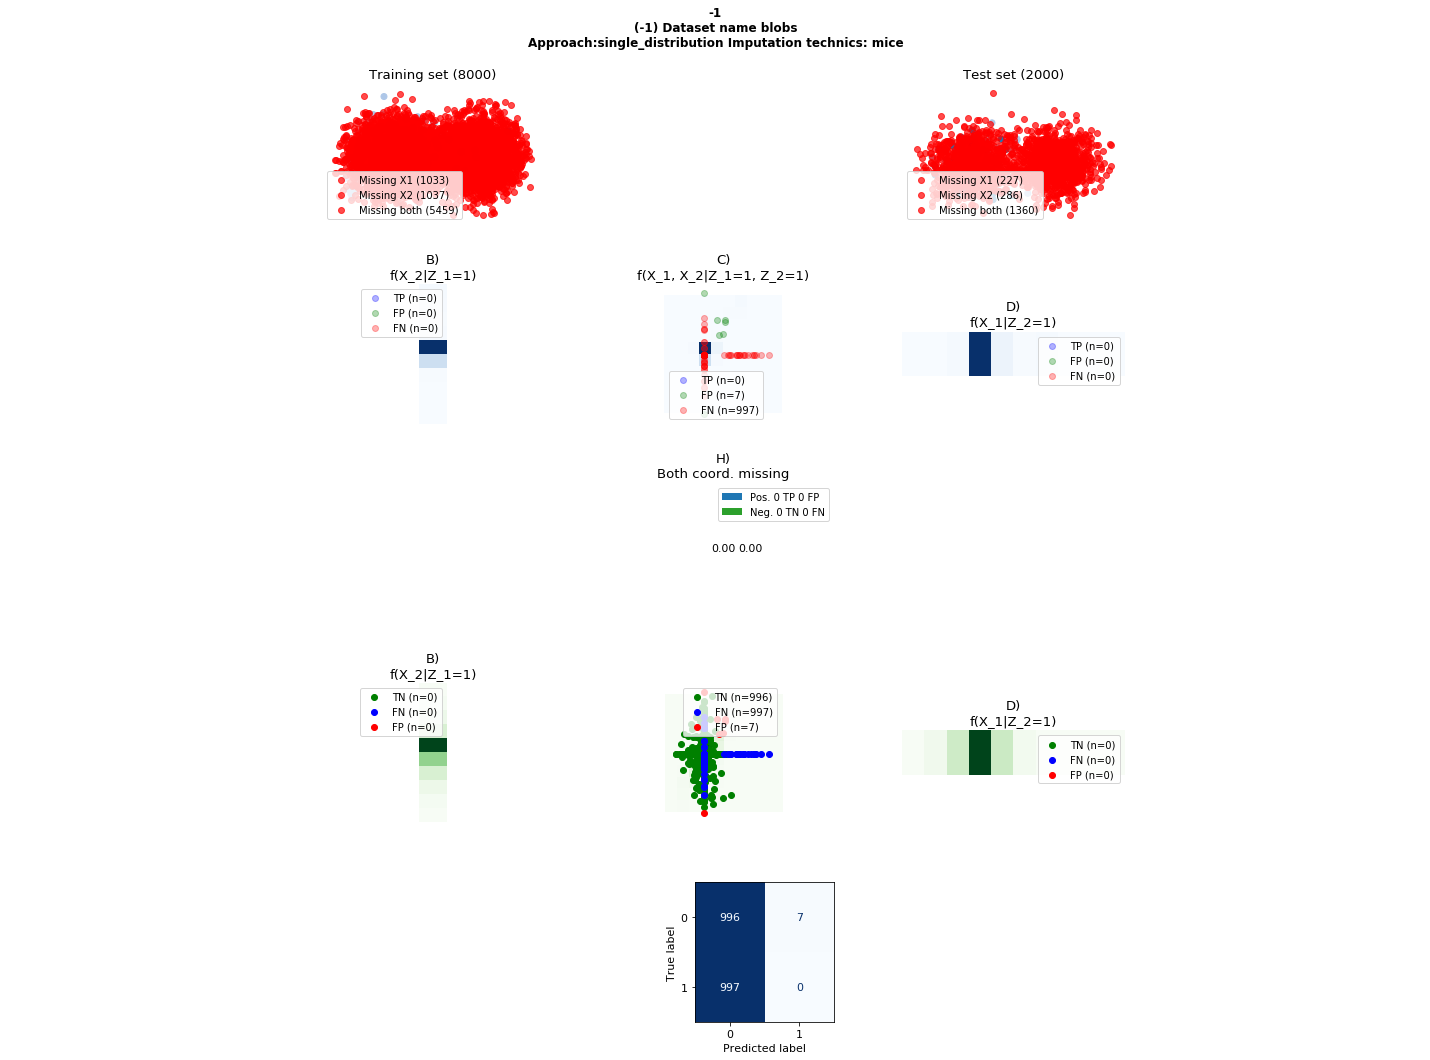

Sample: 997 positive and 1003 negative samples (#p/#n= 99%)



,0
Accuracy,0.498
F1 score (2 PPVxTPR/(PPV+TPR)),0.000
Matthews correlation coefficient (MCC),-0.059
"Sensitivity, recall, hit rate, or true positive rate (TPR)",0.000
"Specificity, selectivity or true negative rate (TNR)",0.993
Precision or positive predictive value (PPV),0.000
Negative predictive value (NPV),0.500
Miss rate or false negative rate (FNR),1.000
False discovery rate (FDR=1-PPV),1.000
False omission rate (FOR=1-NPV),0.500


In [171]:
dataset_name = 'blobs'
approach = 'single_distribution'
missing_data_handling='imputation'
imputation_method='mice'

dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            verbosity=verbosity)

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=4, ratio_of_missing_values=ratio_of_missing_values, ratio_missing_per_class=ratio_missing_per_class)

dataset.split_test_train()

_ = dataset.plot(title=True)


# Change dataset missing data handling
dataset.change_imputation_approach(missing_data_handling=missing_data_handling, imputation_method=imputation_method)

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()

In [ ]:
dataset

In [170]:
X_all = dataset.X_test

idx_out = np.argwhere( (X_all[:,0]>2.5) | (X_all[:,0] < -2.5) | (X_all[:,1]>2.5) | (X_all[:,1] < -2.5) ).squeeze()

X_all[idx_out], labels[idx_out] = datasets.make_blobs(n_samples=len(idx_out), centers=[[-1, 0],[1, 0]],
                                                                    cluster_std=.4, random_state=self.random_state)
idx_out

array([], dtype=int64)

**Creation of the dataset**

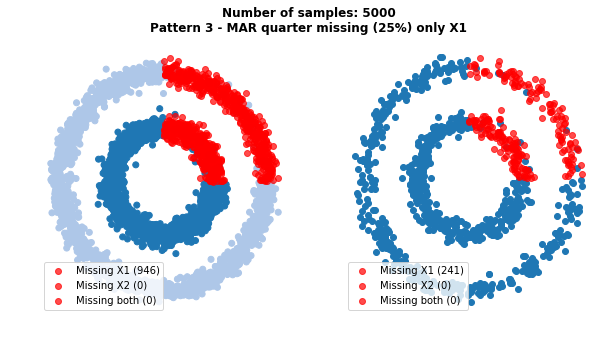

In [4]:
dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            verbosity=verbosity)

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern, ratio_of_missing_values=ratio_of_missing_values, ratio_missing_per_class=ratio_missing_per_class)

dataset.split_test_train()

_ = dataset.plot(title=True)

# Experiment 1) the `multi_ditributions` approach

Experiment 2 loaded successfully! :-)


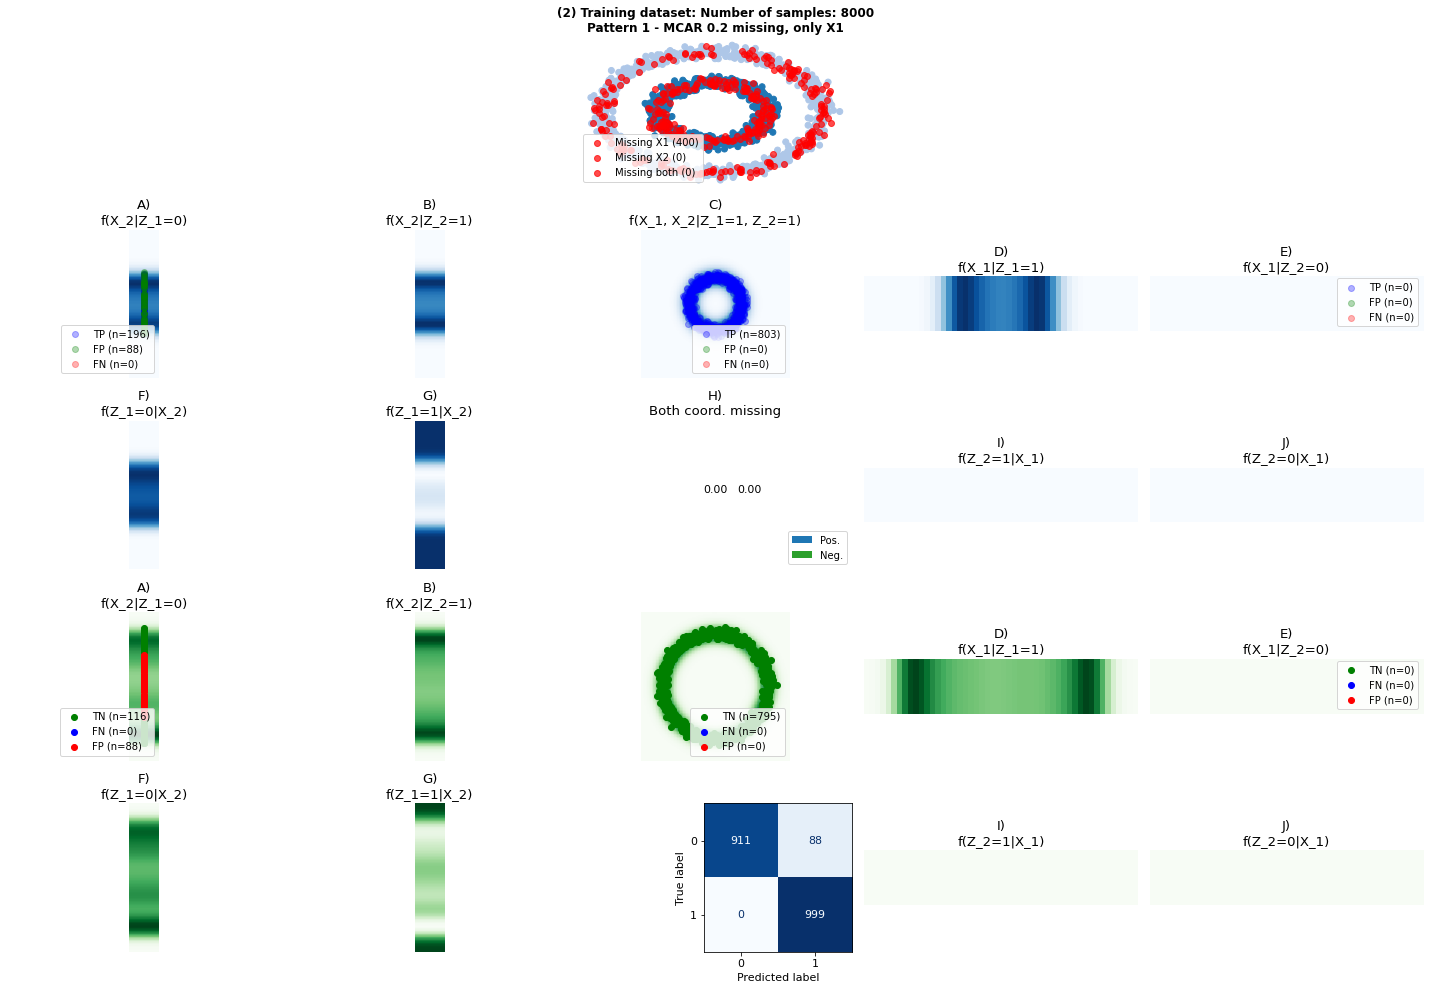

Sample: 999 positive and 999 negative samples (#p/#n=100%)



,0
Accuracy,0.956
F1 score (2 PPVxTPR/(PPV+TPR)),0.958
Matthews correlation coefficient (MCC),0.915
"Sensitivity, recall, hit rate, or true positive rate (TPR)",1.000
"Specificity, selectivity or true negative rate (TNR)",0.912
Precision or positive predictive value (PPV),0.919
Negative predictive value (NPV),1.000
Miss rate or false negative rate (FNR),0.000
False discovery rate (FDR=1-PPV),0.081
False omission rate (FOR=1-NPV),0.000


In [6]:
missing_data_handling='without'
imputation_method='without'
approach = 'multi_distributions'

# Change dataset missing data handling
dataset.change_imputation_approach(missing_data_handling=missing_data_handling, imputation_method=imputation_method)

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()

# Experiment 2) The `single_distribution` approaches


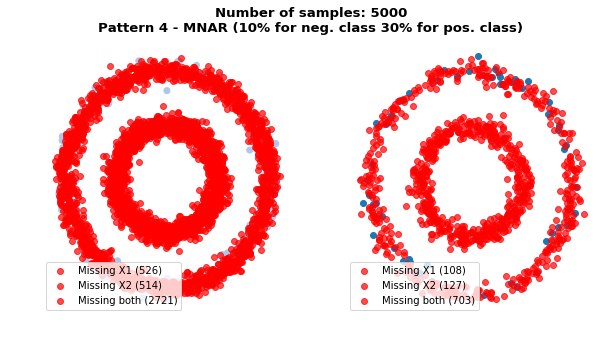

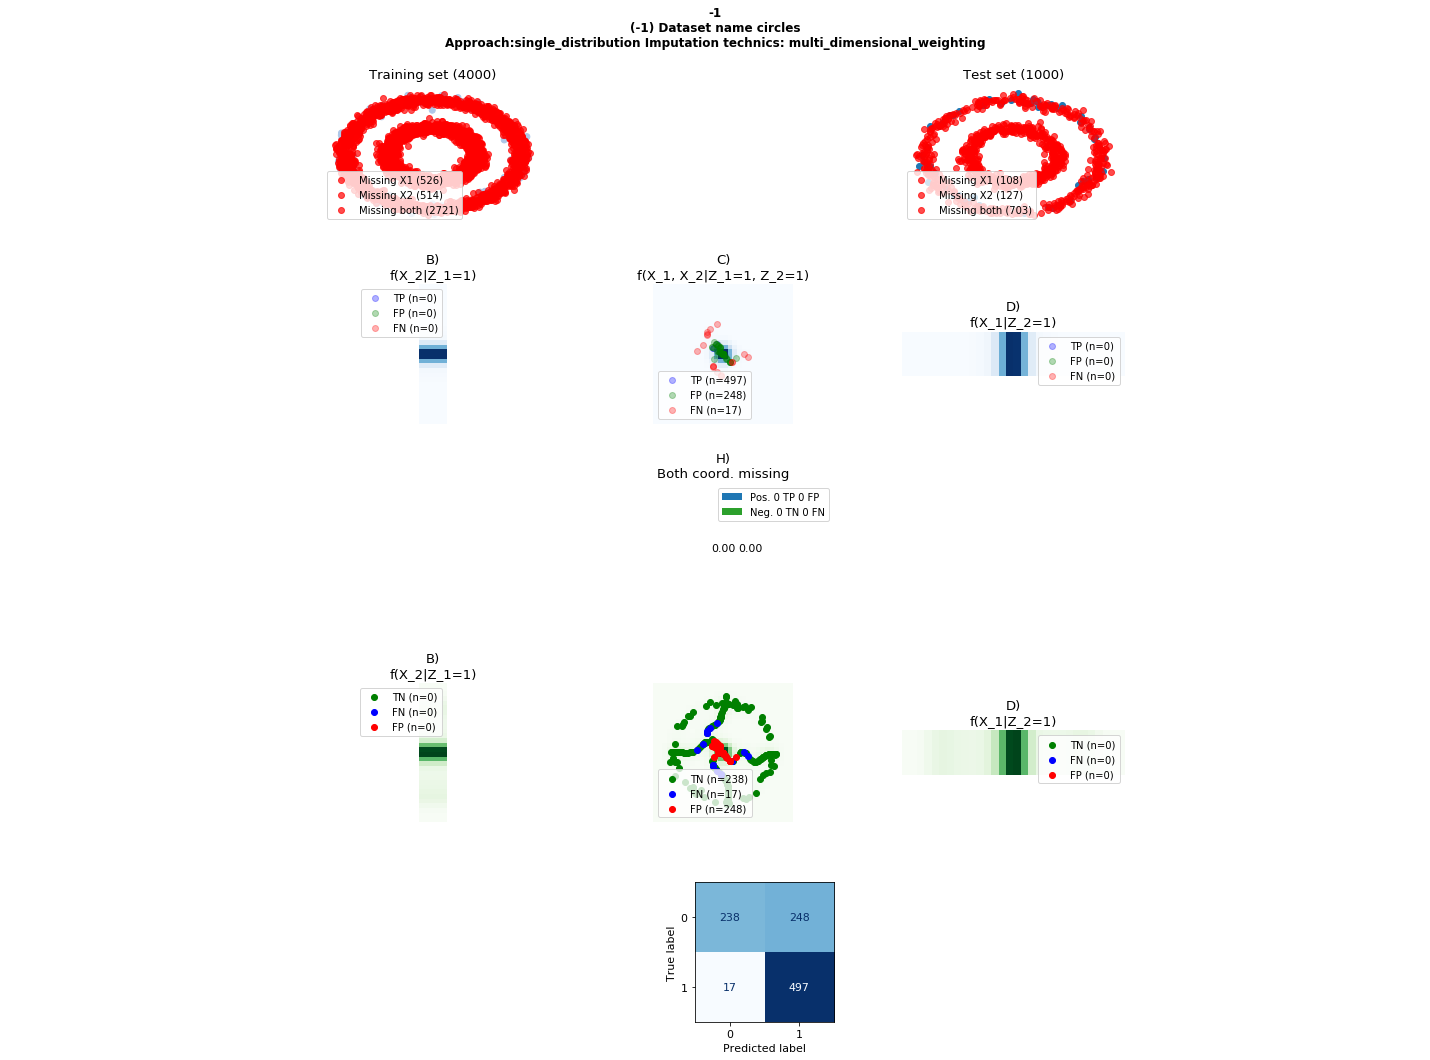

Sample: 514 positive and 486 negative samples (#p/#n=106%)



,0
Accuracy,0.735
F1 score (2 PPVxTPR/(PPV+TPR)),0.790
Matthews correlation coefficient (MCC),0.524
"Sensitivity, recall, hit rate, or true positive rate (TPR)",0.967
"Specificity, selectivity or true negative rate (TNR)",0.490
Precision or positive predictive value (PPV),0.667
Negative predictive value (NPV),0.933
Miss rate or false negative rate (FNR),0.033
False discovery rate (FDR=1-PPV),0.333
False omission rate (FOR=1-NPV),0.067


In [227]:
approach = 'single_distribution'
missing_data_handling='imputation'
imputation_method='multi_dimensional_weighting'

dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            verbosity=verbosity)

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=4, ratio_of_missing_values=ratio_of_missing_values, ratio_missing_per_class=ratio_missing_per_class)

dataset.split_test_train()

_ = dataset.plot(title=True)


# Change dataset missing data handling
dataset.change_imputation_approach(missing_data_handling=missing_data_handling, imputation_method=imputation_method)

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()

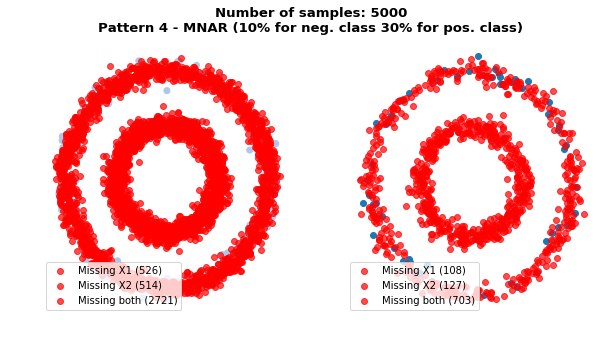

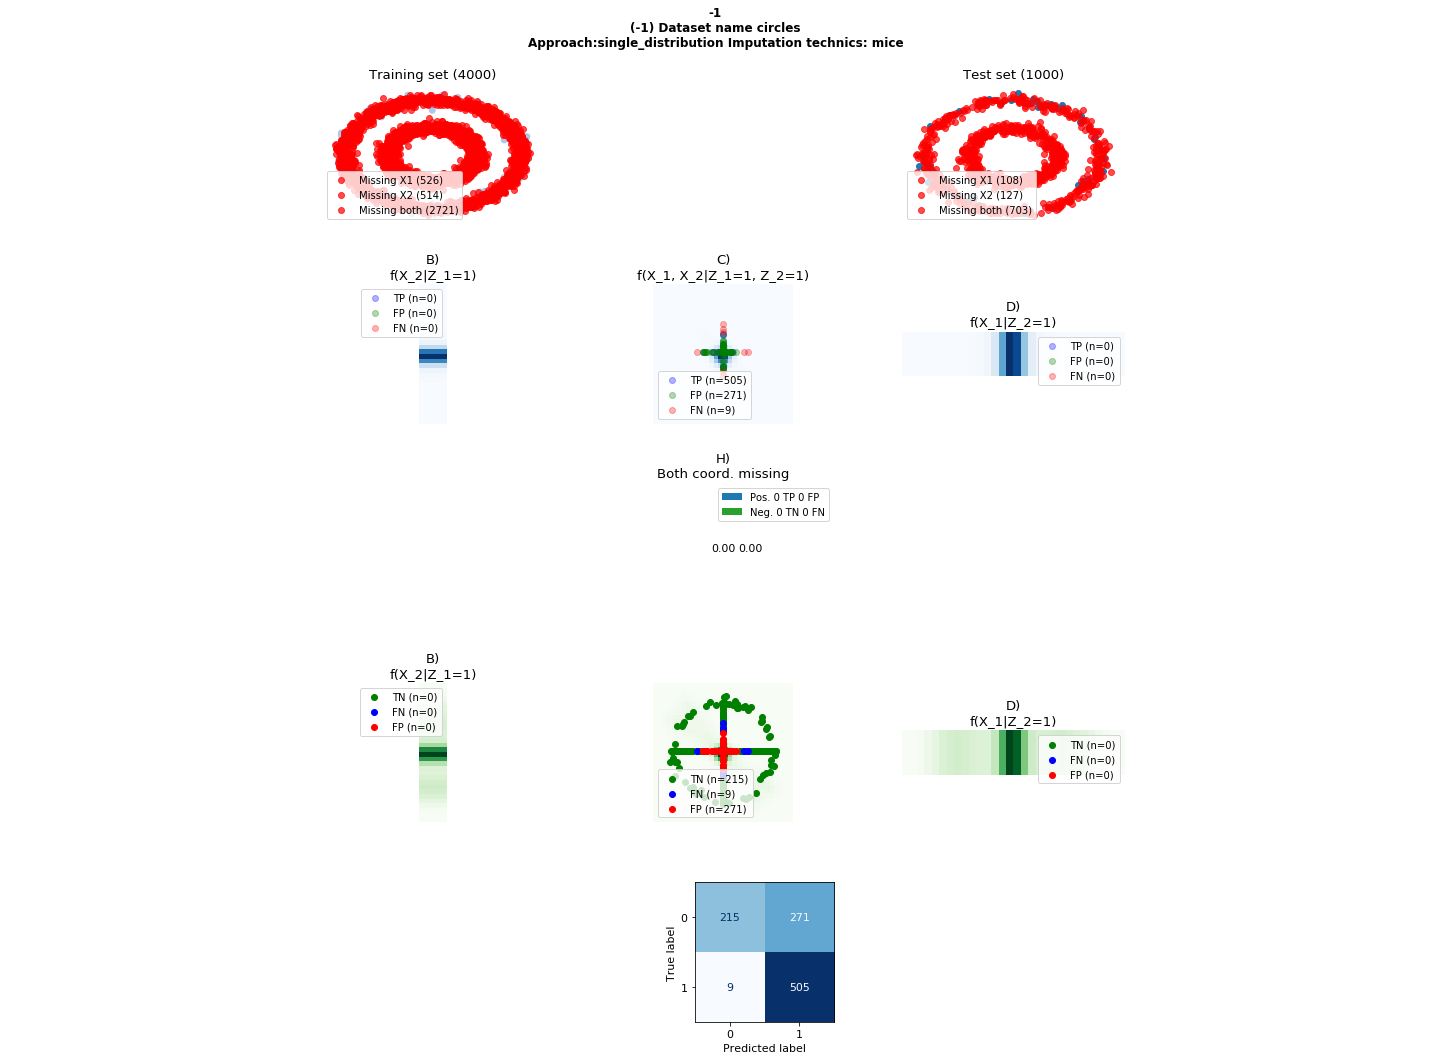

Sample: 514 positive and 486 negative samples (#p/#n=106%)



,0
Accuracy,0.720
F1 score (2 PPVxTPR/(PPV+TPR)),0.783
Matthews correlation coefficient (MCC),0.509
"Sensitivity, recall, hit rate, or true positive rate (TPR)",0.982
"Specificity, selectivity or true negative rate (TNR)",0.442
Precision or positive predictive value (PPV),0.651
Negative predictive value (NPV),0.960
Miss rate or false negative rate (FNR),0.018
False discovery rate (FDR=1-PPV),0.349
False omission rate (FOR=1-NPV),0.040


In [186]:
approach = 'single_distribution'
missing_data_handling='imputation'
imputation_method='mice'

dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            verbosity=verbosity)

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=4, ratio_of_missing_values=ratio_of_missing_values, ratio_missing_per_class=ratio_missing_per_class)

dataset.split_test_train()

_ = dataset.plot(title=True)


# Change dataset missing data handling
dataset.change_imputation_approach(missing_data_handling=missing_data_handling, imputation_method=imputation_method)

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()

# Experiment 3) Neural Additive Networks

	===== Replicate no. 1 =====

Epoch: 1/20;	 Batch: 1/250;	 Err: 0.703
Epoch: 1/20;	 Batch: 4/250;	 Err: 0.811
Epoch: 1/20;	 Batch: 7/250;	 Err: 0.804
Epoch: 1/20;	 Batch: 10/250;	 Err: 0.827
Epoch: 1/20;	 Batch: 13/250;	 Err: 0.832
Epoch: 1/20;	 Batch: 16/250;	 Err: 0.729
Epoch: 1/20;	 Batch: 19/250;	 Err: 0.753
Epoch: 1/20;	 Batch: 22/250;	 Err: 0.823
Epoch: 1/20;	 Batch: 25/250;	 Err: 0.741
Epoch: 1/20;	 Batch: 28/250;	 Err: 0.767
Epoch: 1/20;	 Batch: 31/250;	 Err: 0.707
Epoch: 1/20;	 Batch: 34/250;	 Err: 0.708
Epoch: 1/20;	 Batch: 37/250;	 Err: 0.717
Epoch: 1/20;	 Batch: 40/250;	 Err: 0.721
Epoch: 1/20;	 Batch: 43/250;	 Err: 0.779
Epoch: 1/20;	 Batch: 46/250;	 Err: 0.739
Epoch: 1/20;	 Batch: 49/250;	 Err: 0.734
Epoch: 1/20;	 Batch: 52/250;	 Err: 0.731
Epoch: 1/20;	 Batch: 55/250;	 Err: 0.790
Epoch: 1/20;	 Batch: 58/250;	 Err: 0.792
Epoch: 1/20;	 Batch: 61/250;	 Err: 0.765
Epoch: 1/20;	 Batch: 64/250;	 Err: 0.700
Epoch: 1/20;	 Batch: 67/250;	 Err: 0.757
Epoch: 1/20;	 Batch: 70/250;	 

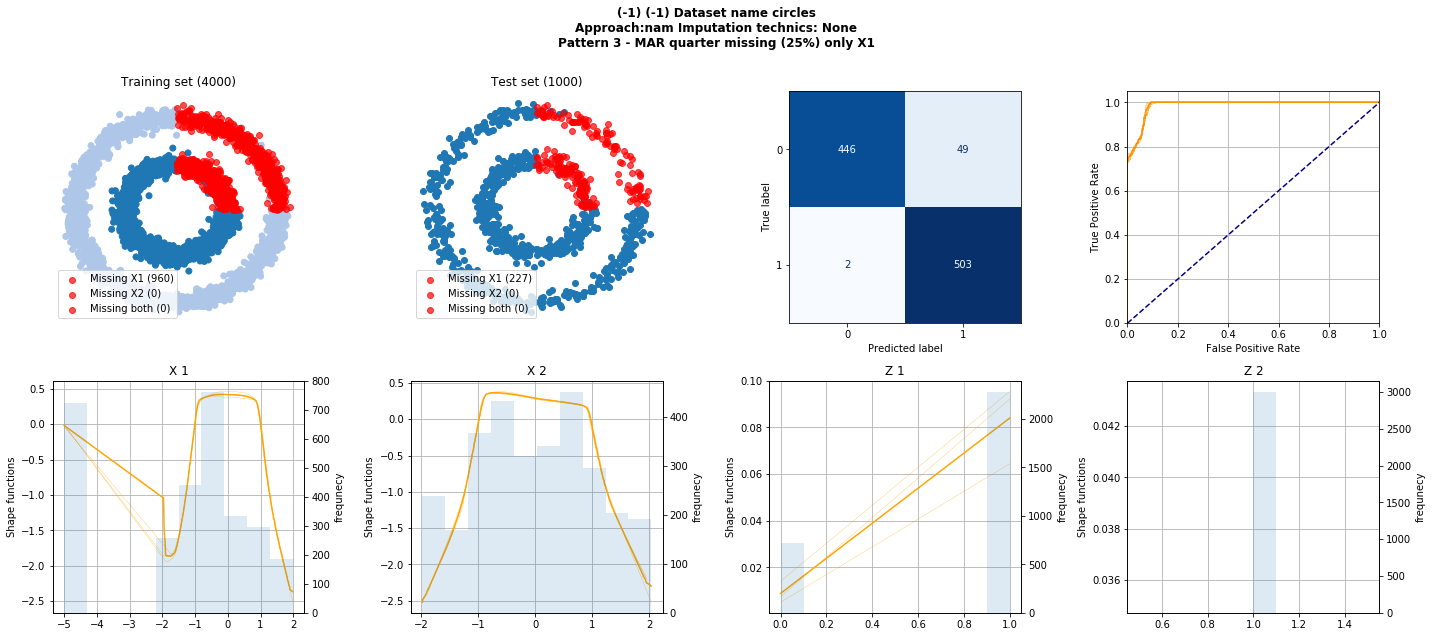

In [5]:
approach = 'nam'
missing_data_handling='encoding'
imputation_method=None
use_missing_indicator_variables = True

# Change dataset missing data handling
dataset.change_imputation_approach(missing_data_handling=missing_data_handling, imputation_method=imputation_method)

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=3, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit(use_missing_indicator_variables=use_missing_indicator_variables)

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()

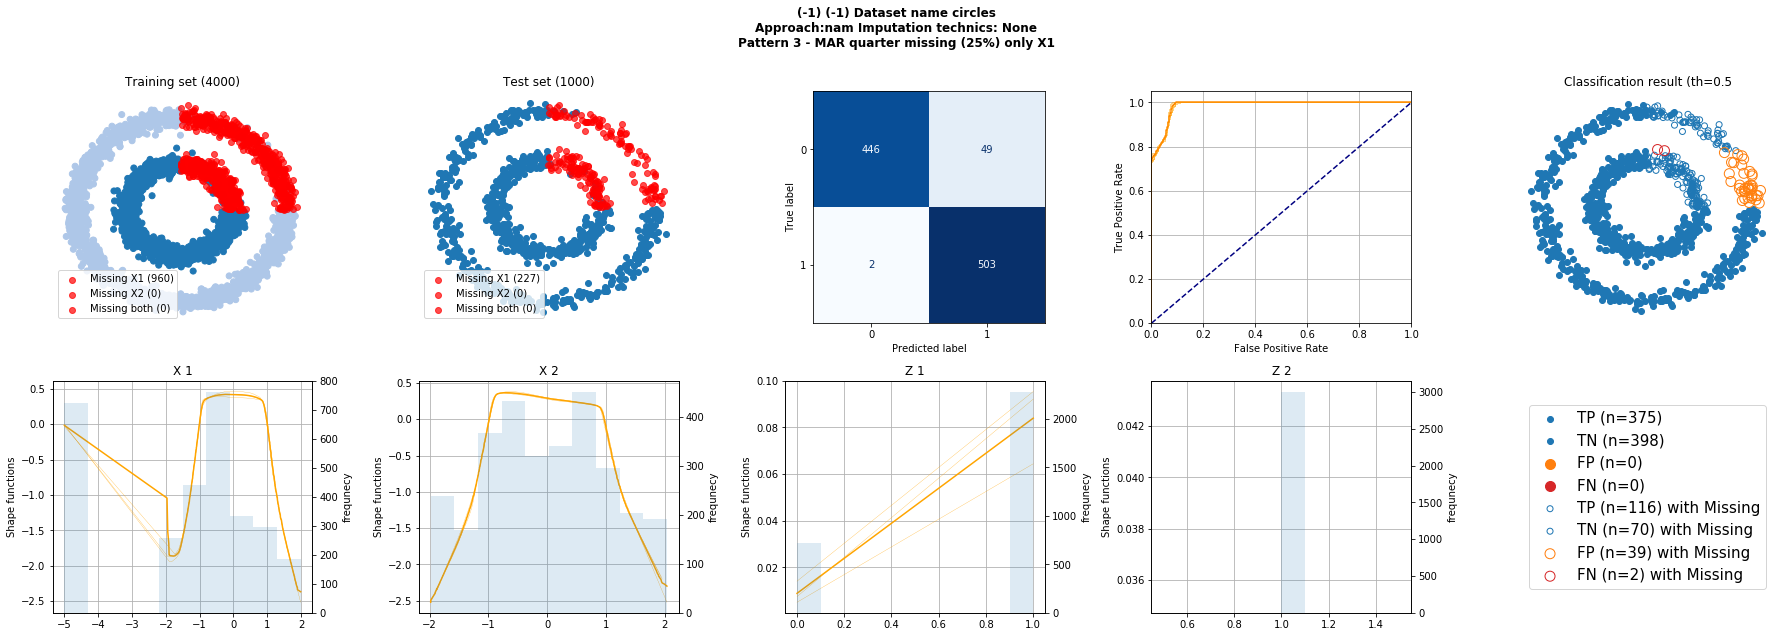

In [39]:
exp.plot()

#### Quantitative results

Loading experiment 227
This experiemnt did not have the best model saved at that time, sorry! Re-do experiment.
Experiment 227 loaded successfully! :-)


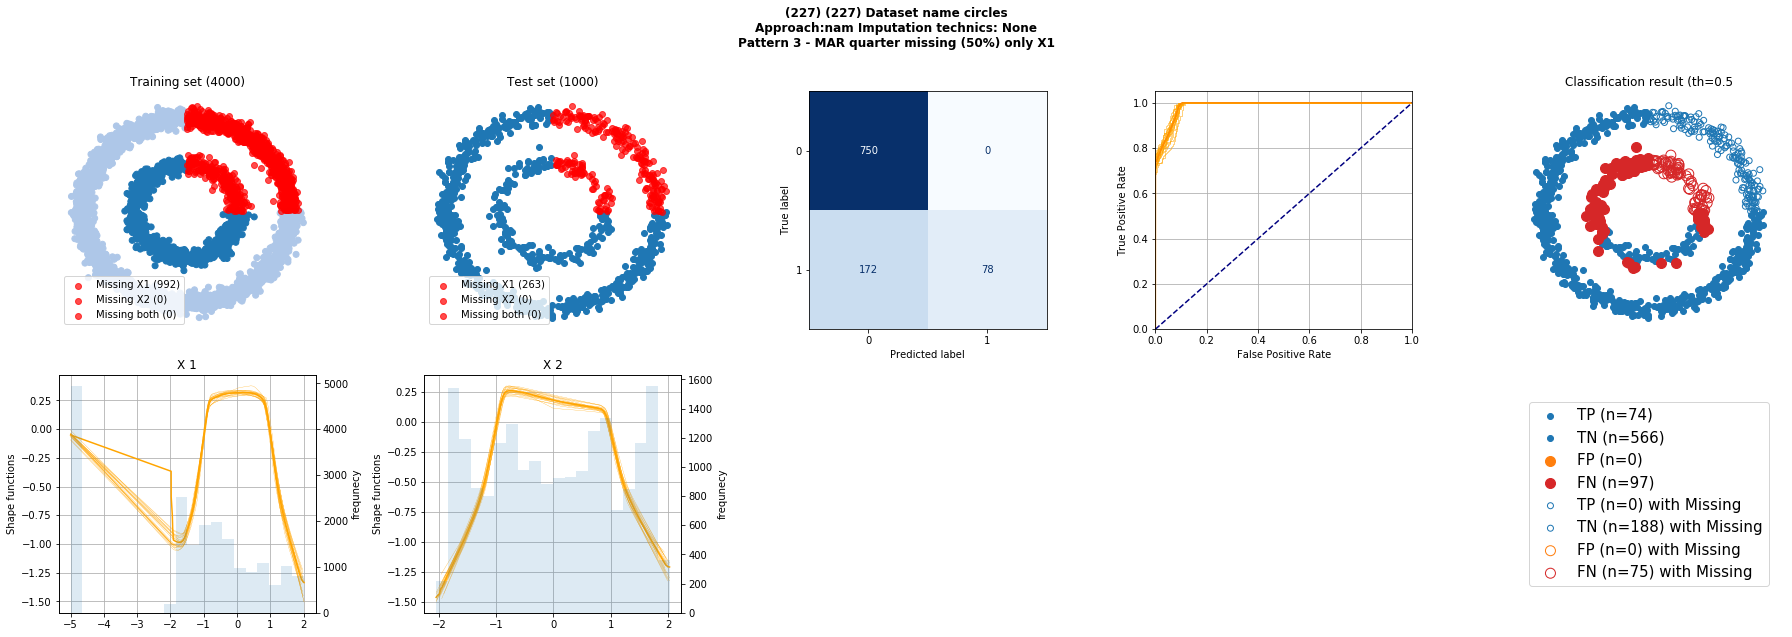

In [126]:
dataset_name= 'circles'
random_experiment = df.query(" `dataset_name` == @dataset_name &`approach` == 'nam'")['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = 'nam', 
                  previous_experiment=random_experiment, 
                  save_experiment=False, 
                  verbosity=3, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

exp.predict()
# Plot results
exp.plot()

Loading experiment 214
This experiemnt did not have the best model saved at that time, sorry! Re-do experiment.
Experiment 214 loaded successfully! :-)


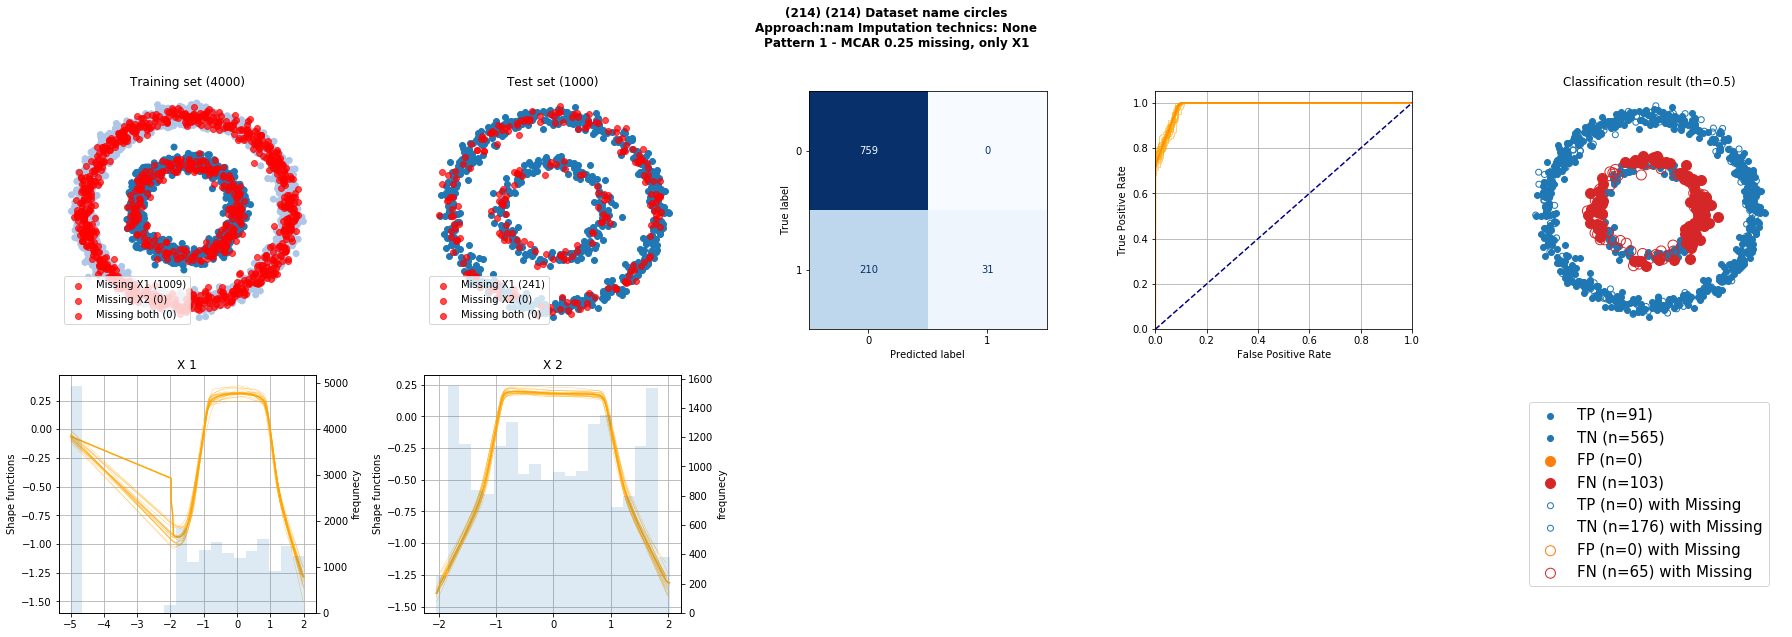

In [128]:
dataset_name= 'circles'
random_experiment = df.query(" `dataset_name` == @dataset_name &`approach` == 'nam'")['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = 'nam', 
                  previous_experiment=random_experiment, 
                  save_experiment=False, 
                  verbosity=3, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

exp.predict()
# Plot results
exp.plot()

Loading experiment 51
This experiemnt did not have the best model saved at that time, sorry! Re-do experiment.
Experiment 51 loaded successfully! :-)


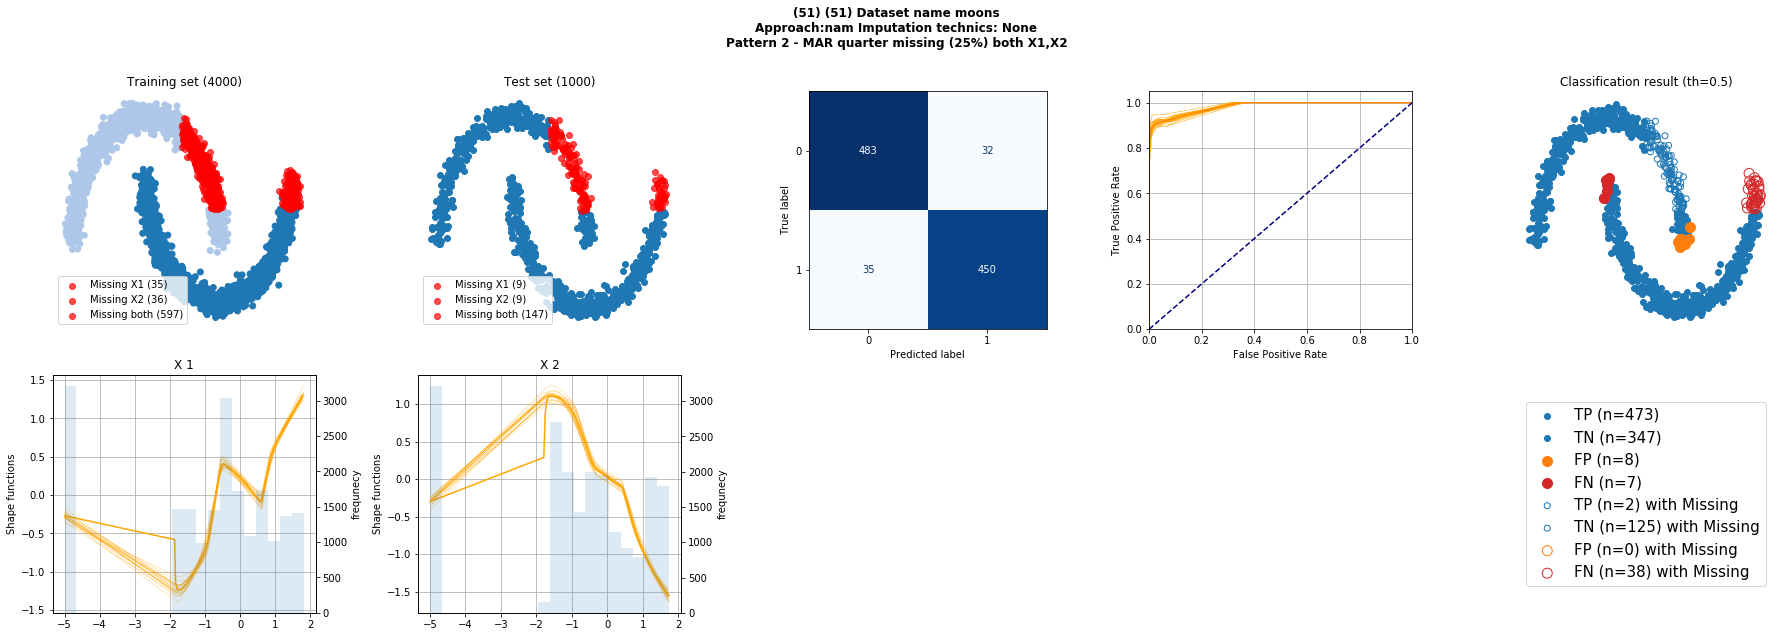

In [129]:
dataset_name= 'moons'
random_experiment = df.query(" `dataset_name` == @dataset_name &`approach` == 'nam'")['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = 'nam', 
                  previous_experiment=random_experiment, 
                  save_experiment=False, 
                  verbosity=3, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

exp.predict()
# Plot results
exp.plot()

Loading experiment 30
This experiemnt did not have the best model saved at that time, sorry! Re-do experiment.
Experiment 30 loaded successfully! :-)


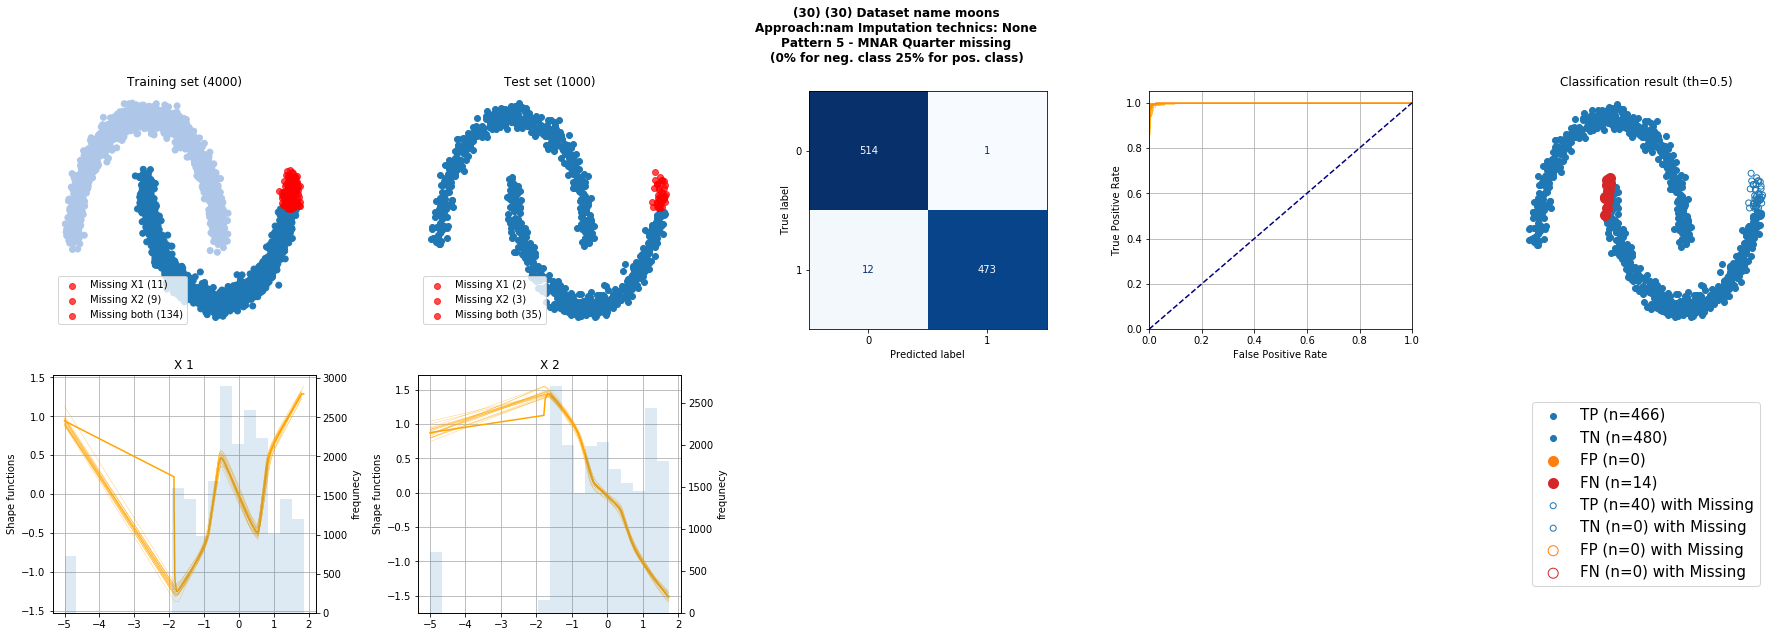

In [130]:
dataset_name= 'moons'
random_experiment = df.query(" `dataset_name` == @dataset_name &`approach` == 'nam'")['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = 'nam', 
                  previous_experiment=random_experiment, 
                  save_experiment=False, 
                  verbosity=3, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)`

exp.predict()
# Plot results
exp.plot()

Loading experiment 33
This experiemnt did not have the best model saved at that time, sorry! Re-do experiment.
Experiment 33 loaded successfully! :-)


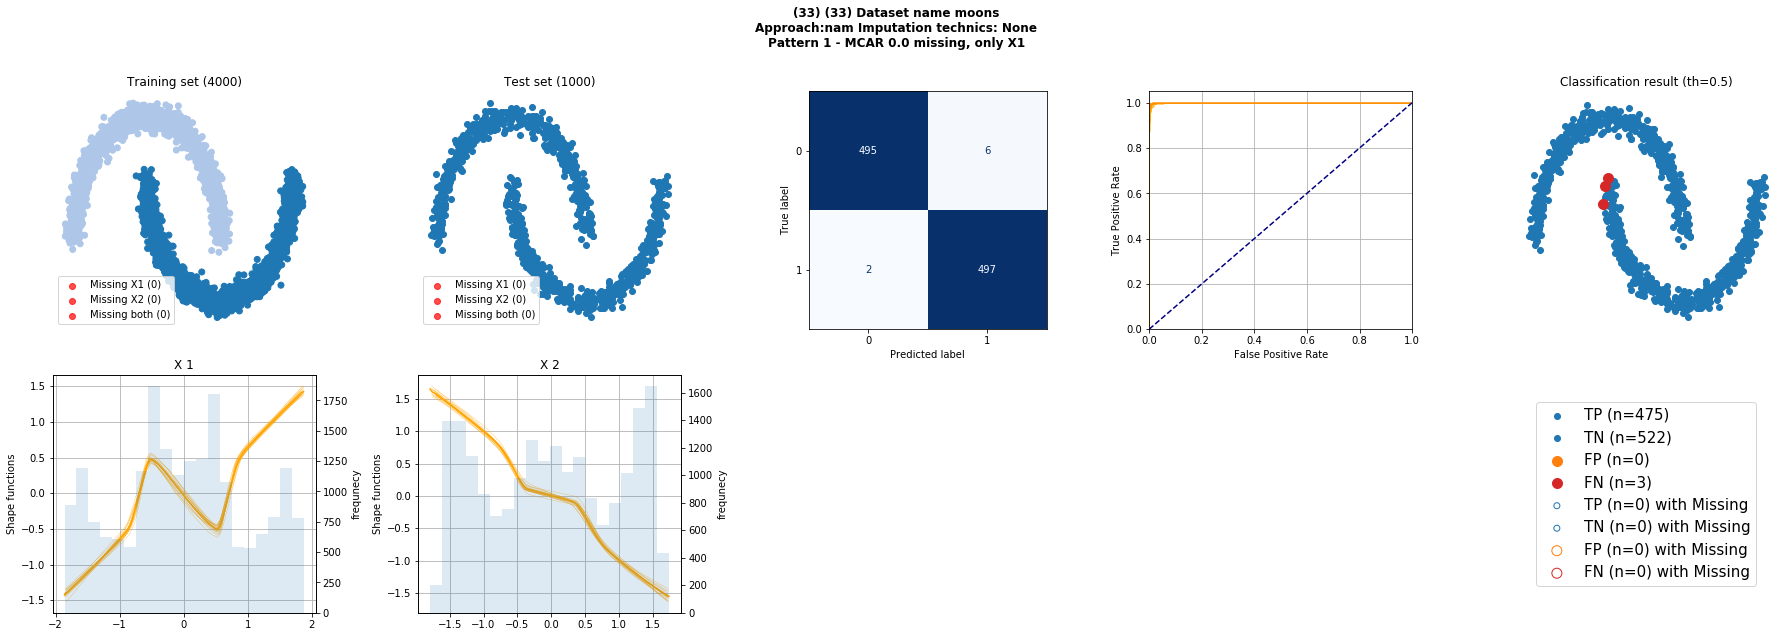

In [132]:
dataset_name= 'moons'
random_experiment = df.query(" `dataset_name` == @dataset_name &`approach` == 'nam'")['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = 'nam', 
                  previous_experiment=random_experiment, 
                  save_experiment=False, 
                  verbosity=3, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

exp.predict()
# Plot results
exp.plot()

# Figure creation

In [1]:
df = create_df()
df.replace({None:np.nan}, inplace=True)
df.query(" `num_samples` >= @NUM_SAMPLES")

NameError: name 'create_df' is not defined

In [229]:
dataset_name = 'circles'

df_of_interest = df.query("`dataset_name` == @dataset_name ")
df_of_interest = df_of_interest.query("`ratio_of_missing_values`<0.45")
df_of_interest = df_of_interest.query(" (`approach` == 'single_distribution' &`imputation_method`=='multi_dimensional_weighting') | `approach` != 'single_distribution'")
df_of_interest.ratio_of_missing_values = df_of_interest.ratio_of_missing_values.round(1)
df_of_interest.sort_values(by='approach', inplace=True)

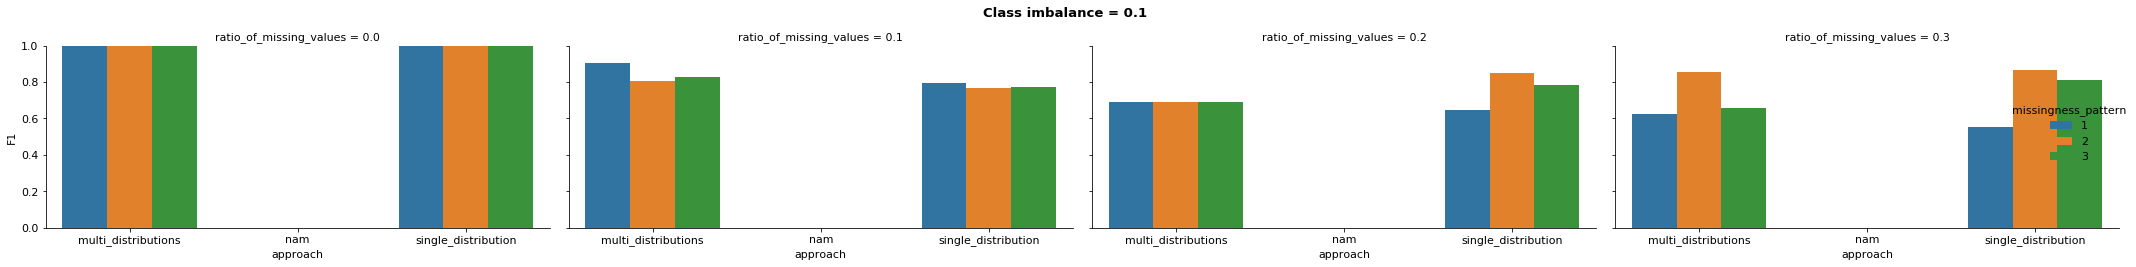

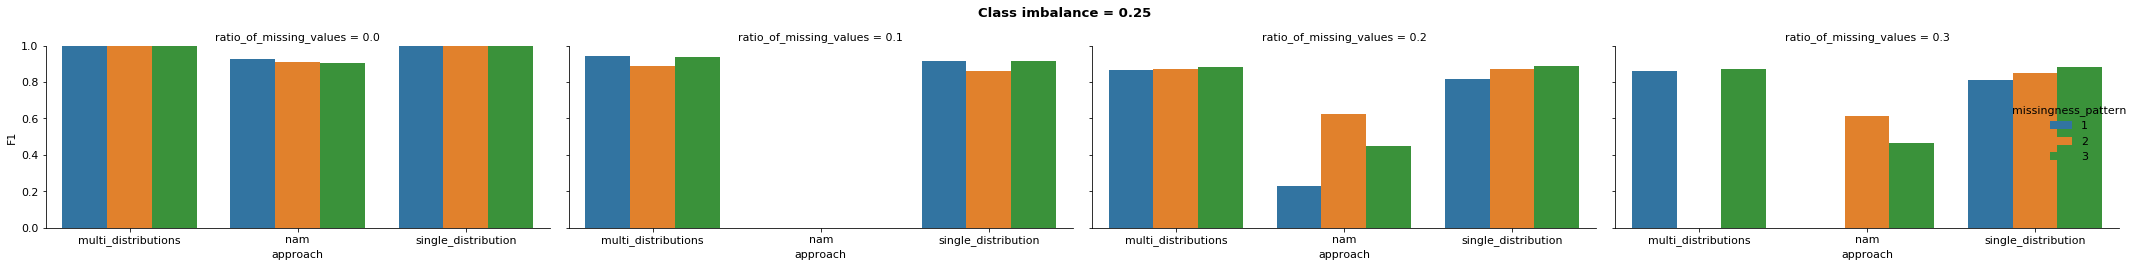

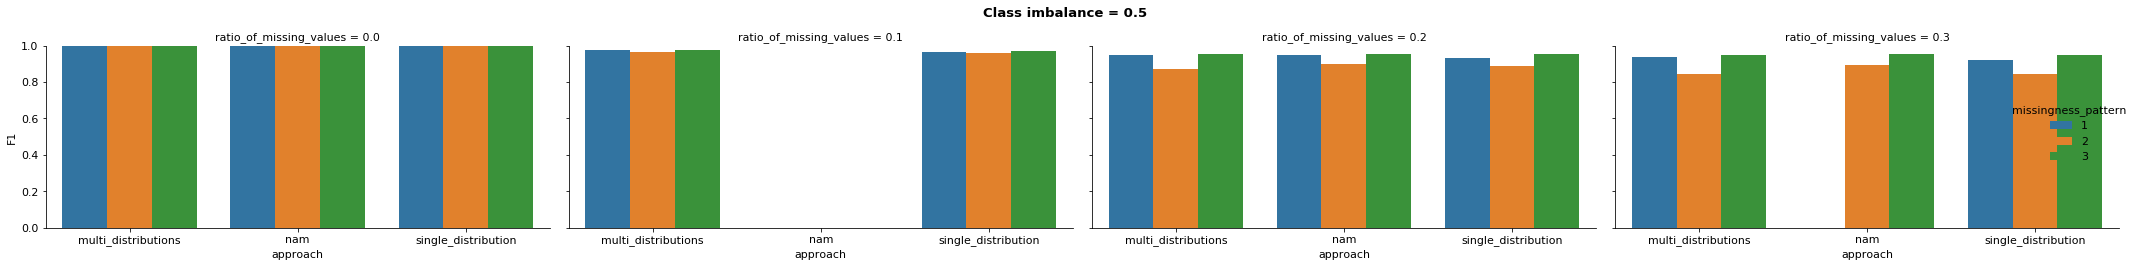

In [231]:


for class_imbalance in df_of_interest['imbalance_ratio'].sort_values().unique():
    if class_imbalance==0.05:
        continue
    g = sns.factorplot("approach", "F1", "missingness_pattern", col="ratio_of_missing_values", data=df_of_interest.query("`missingness_pattern` in [1, 2, 3] & `imbalance_ratio`==@class_imbalance"), kind="bar", ci=False, height=3.5, aspect=2, y=(0,1))
    
    g.fig.suptitle('Class imbalance = {}'.format(class_imbalance), weight='bold', y=1.05)
    for ax in g.axes_dict.values():
        ax.set_ylim([0,1])
    
    plt.tight_layout();plt.show()

In [232]:
df_nam = df.query(" `approach` == 'nam' & `dataset_name` == @dataset_name ").sort_values(by='imputation_method')
df_nam.replace({None:np.nan}, inplace=True)
df_nam = df_nam.query("`ratio_of_missing_values`<0.45")

df_nam.ratio_of_missing_values = df_nam.ratio_of_missing_values.apply(lambda x: 0.24 if 0.24 < x and x < 0.251 else x)
df_nam.ratio_of_missing_values = df_nam.ratio_of_missing_values.round(1)

#df_nam

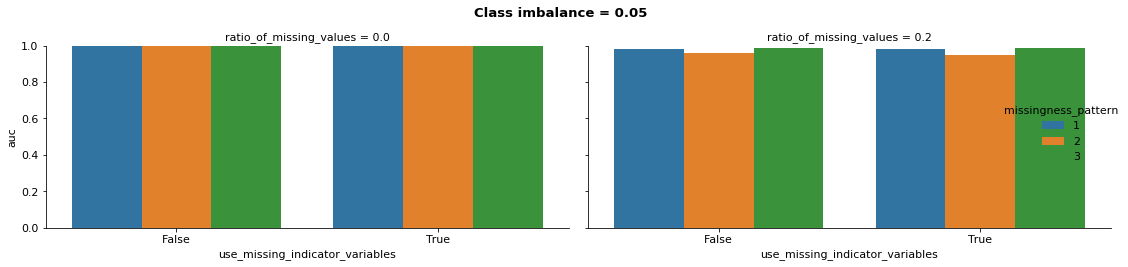

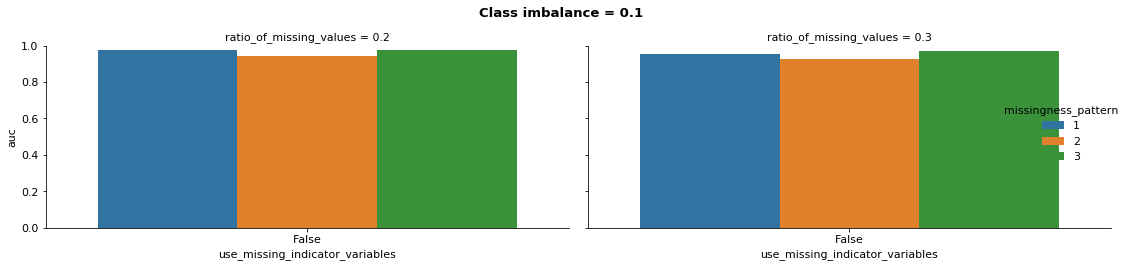

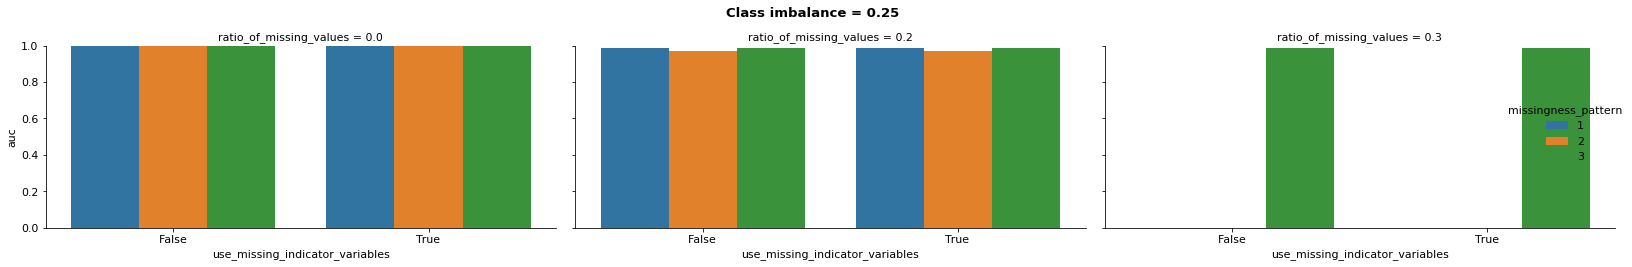

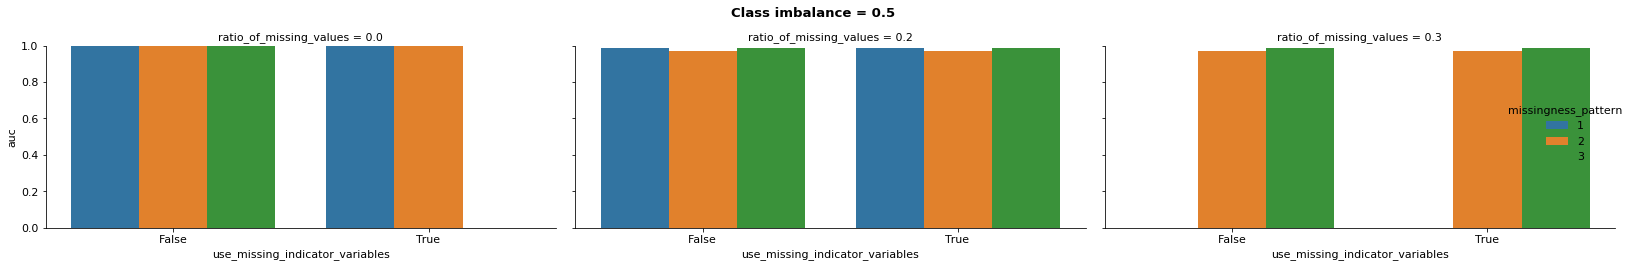

In [234]:
for class_imbalance in df_nam['imbalance_ratio'].sort_values().unique():
    #if class_imbalance==0.1:
    #    continue
    g = sns.factorplot("use_missing_indicator_variables", "auc", "missingness_pattern", col="ratio_of_missing_values", data=df_nam.query("`missingness_pattern` in [1, 2, 3] & `imbalance_ratio`==@class_imbalance"), kind="bar", ci=False, height=3.5, aspect=2)
    g.fig.suptitle('Class imbalance = {}'.format(class_imbalance), weight='bold', y=1.05)
    for ax in g.axes_dict.values():
        ax.set_ylim([0,1])
    
    plt.tight_layout();plt.show()

In [237]:
dataset_name = 'circles'
df_experiement = df.query(" `approach` == 'single_distribution' & `dataset_name` == @dataset_name ").sort_values(by='imputation_method')

df_experiement.replace({"multi_dimensional_weighting":'ours'}, inplace=True)
df_experiement = df_experiement.query("`ratio_of_missing_values`<0.45")

df_experiement.ratio_of_missing_values = df_experiement.ratio_of_missing_values.apply(lambda x: 0.24 if 0.24 < x and x < 0.251 else x)
df_experiement.ratio_of_missing_values = df_experiement.ratio_of_missing_values.round(1)
df_experiement.ratio_missing_per_class_0 = df_experiement.ratio_missing_per_class_0.round(2)
df_experiement.ratio_missing_per_class_1 = df_experiement.ratio_missing_per_class_1.round(2)

df_experiement.drop(index=df_experiement.query(" `ratio_missing_per_class_1` > .5").index, inplace=True)


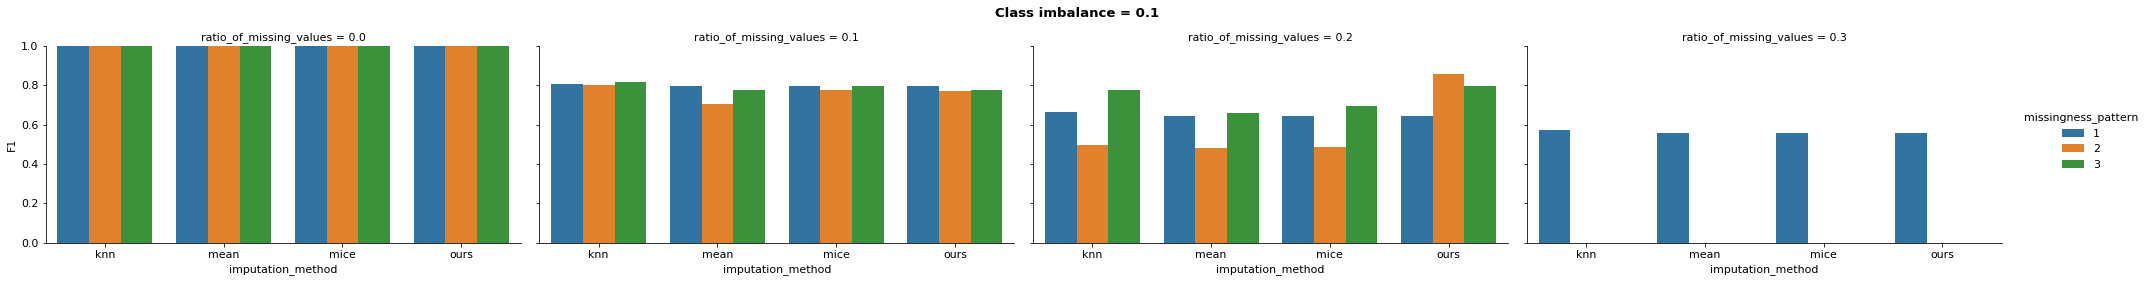

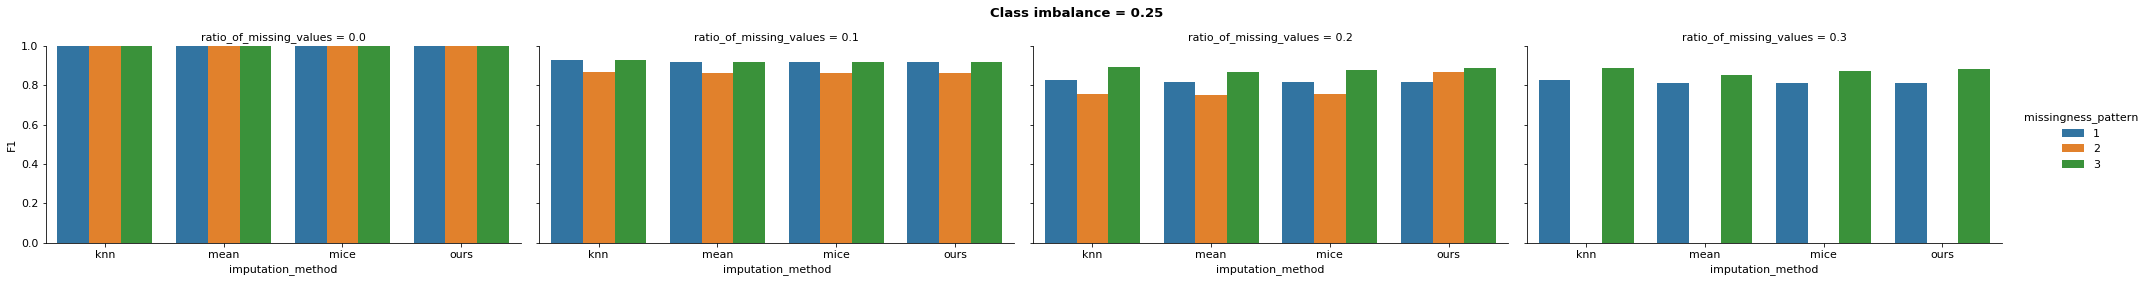

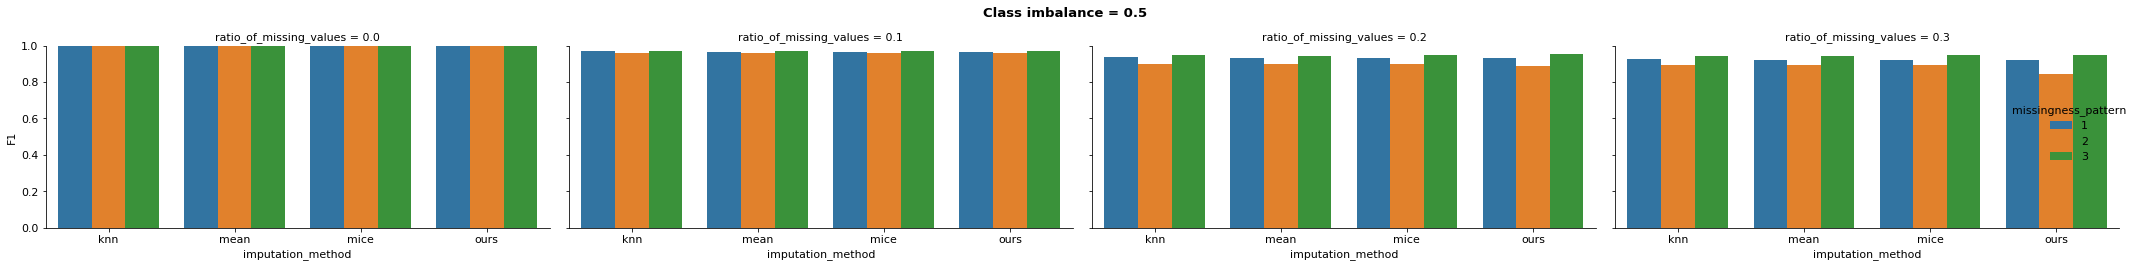

In [239]:
for class_imbalance in df_experiement['imbalance_ratio'].sort_values().unique():
    if class_imbalance==0.05:
        continue
    g = sns.factorplot("imputation_method", "F1", "missingness_pattern", col="ratio_of_missing_values", data=df_experiement.query("`missingness_pattern` in [1, 2, 3] & `imbalance_ratio`==@class_imbalance"), kind="bar", ci=False, height=3.5, aspect=2)
    g.fig.suptitle('Class imbalance = {}'.format(class_imbalance), weight='bold', y=1.05)
    for ax in g.axes_dict.values():
        ax.set_ylim([0,1])
plt.tight_layout()
plt.show()

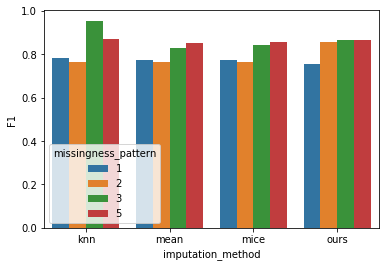

In [180]:
sns.barplot(data=df_experiement, x="imputation_method", y="F1", hue='missingness_pattern', ci=False)

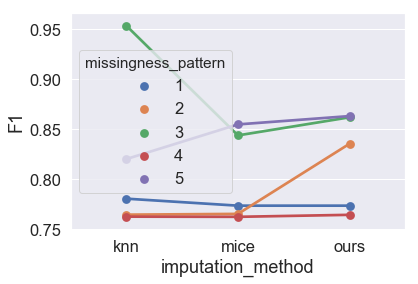

In [ ]:
sns.pointplot(data=df_experiement, x="imputation_method", y="F1", hue='missingness_pattern', ci=False)

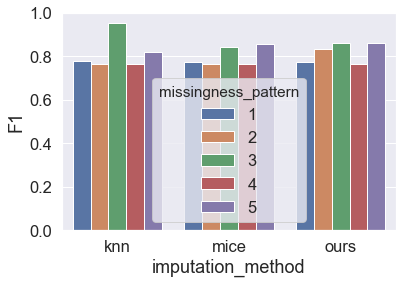

In [ ]:
sns.barplot(data=df_experiement, x="imputation_method", y="F1", hue='missingness_pattern', ci=False)

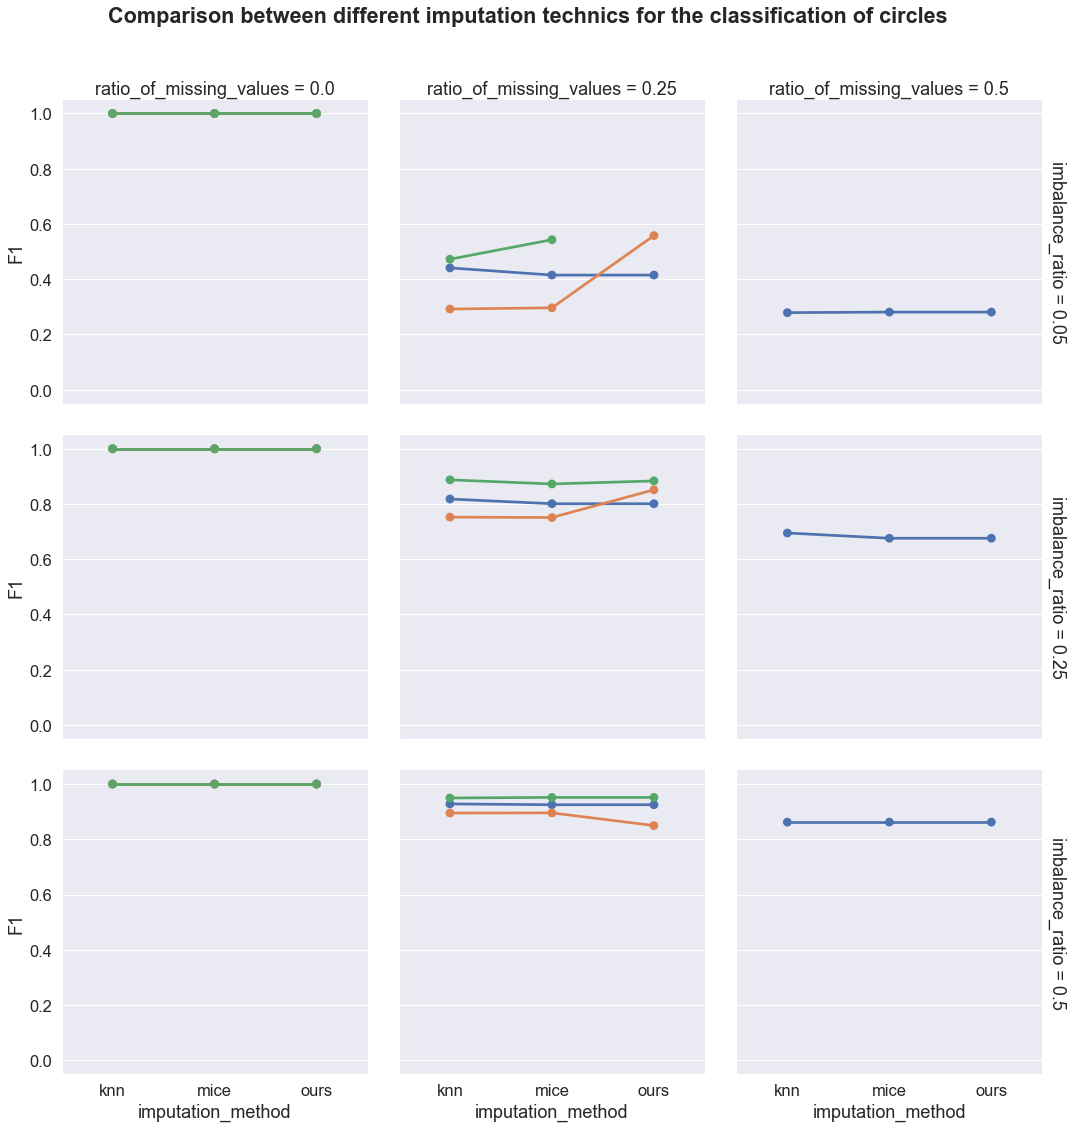

In [204]:
sns.set(font_scale = 1.5)
g = sns.FacetGrid(df_experiement, col="ratio_of_missing_values", row='imbalance_ratio', hue='missingness_pattern', height=5, margin_titles=True, ylim=(-0.05, 1.05))
g.map(sns.pointplot, "imputation_method", "F1",  ci=None)
#for ax in g.axes_dict.values():
#    ax.axline((0, 0), slope=.2, c=".2", ls="--", zorder=0)
g.fig.suptitle('Comparison between different imputation technics for the classification of {}'.format(dataset_name), weight='bold', y=1.05)
plt.tight_layout()
plt.show()

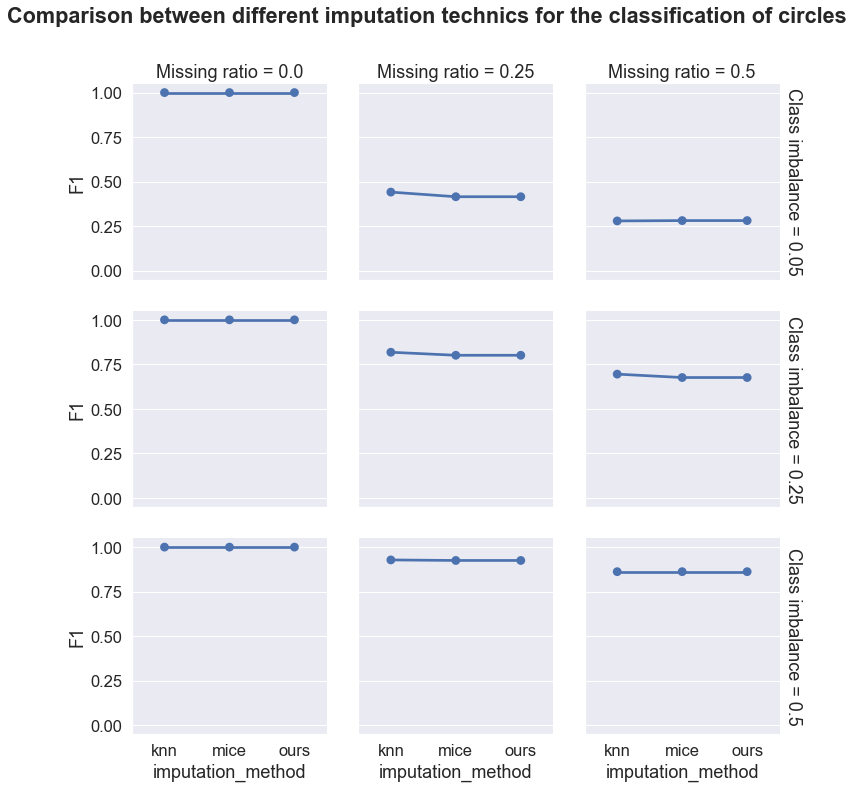

In [152]:
sns.set(font_scale = 1.5)
g = sns.FacetGrid(df_experiement, col="ratio_of_missing_values", row='imbalance_ratio', height=3.5, margin_titles=True, ylim=(-0.05, 1.05))
g.map(sns.pointplot, "imputation_method", "F1", order=['knn', 'mice', 'ours'], ci=None, label='F1')
#for ax in g.axes_dict.values():
#    ax.axline((0, 0), slope=.2, c=".2", ls="--", zorder=0)
g.fig.suptitle('Comparison between different imputation technics for the classification of {}'.format(dataset_name), weight='bold', y=1.05)
plt.tight_layout()
plt.show()

In [48]:
df.query( "`dataset_name`==@dataset_name & `missingness_pattern`==@missingness_pattern & `ratio_of_missing_values`==.2")

,dataset_name,experiment_number,approach,missing_data_handling,imputation_method,use_missing_indicator_variables,num_samples,imbalance_ratio,missingness_pattern,missingness_mechanism,ratio_of_missing_values,missing_X1,missing_X2,missing_first_quarter,ratio_missing_per_class_0,ratio_missing_per_class_1,auc,Accuracy,F1,MCC,Sensitivity,Specificity,Precision,PPV,NPV,FNR,FDR,FOR,resolution,bandwidth,estimation_time_0,estimation_time_1


Text(0.5,1,'Performances when Accuracy evolves\nDataset: moons and MP: 3')

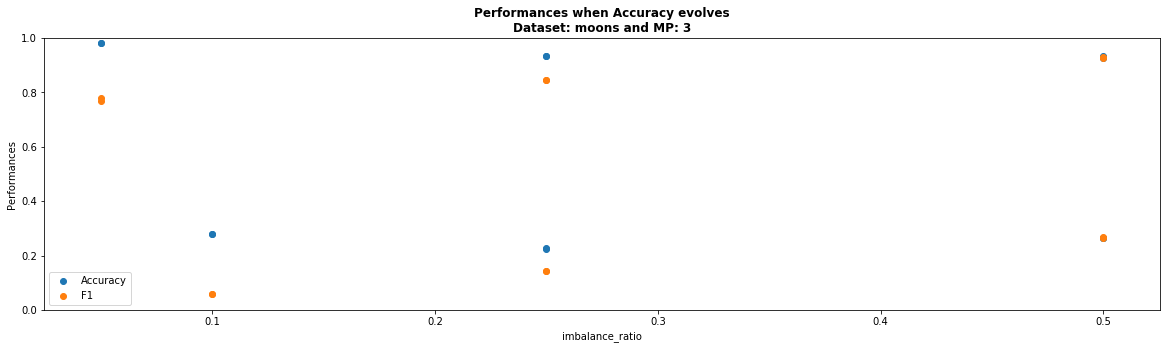

In [49]:
missingness_pattern=3
dataset_name = 'moons'



xname = 'imbalance_ratio'
yname = 'Accuracy'
yname2 = 'F1'

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.scatter(df.query( "`dataset_name`==@dataset_name & `missingness_pattern`==@missingness_pattern & `ratio_of_missing_values`==.2")[xname], 
df.query( "`dataset_name`==@dataset_name & `missingness_pattern`==@missingness_pattern & `ratio_of_missing_values`==.2")[yname], label=yname)
ax.scatter(df.query( "`dataset_name`==@dataset_name & `missingness_pattern`==@missingness_pattern & `ratio_of_missing_values`==.2")[xname], 
df.query( "`dataset_name`==@dataset_name & `missingness_pattern`==@missingness_pattern & `ratio_of_missing_values`==.2")[yname2], label=yname2)
#ax.scatter(df_moons.query( "`missingness_pattern`==@missingness_pattern")[xname], df_moons.query( "`missingness_pattern`==@missingness_pattern")[yname], label='moons')
ax.set_ylim([0,1])
plt.legend()

ax.set_xlabel(xname);ax.set_ylabel('Performances');ax.set_title("Performances when {} evolves\nDataset: {} and MP: {}".format(yname, dataset_name, missingness_pattern), weight='bold')


In [45]:
df

,dataset_name,experiment_number,approach,missing_data_handling,imputation_method,use_missing_indicator_variables,num_samples,imbalance_ratio,missingness_pattern,missingness_mechanism,ratio_of_missing_values,missing_X1,missing_X2,missing_first_quarter,ratio_missing_per_class_0,ratio_missing_per_class_1,auc,Accuracy,F1,MCC,Sensitivity,Specificity,Precision,PPV,NPV,FNR,FDR,FOR,resolution,bandwidth,estimation_time_0,estimation_time_1
0,moons,61,multi_distributions,without,without,NaN,5000,0.25,4,MNAR,NaN,True,True,False,0.0000,0.9404,NaN,0.44200,0.49800,0.2750,1.00000,0.228,0.332,0.332,1.00000,0.00000,0.668,0.00000,30,0.2,NaN,NaN
1,moons,59,multi_distributions,without,without,NaN,5000,0.25,3,MAR,0.2,True,False,True,NaN,NaN,NaN,0.22400,0.14200,-0.4820,0.25700,0.213,0.098,0.098,0.46400,0.74300,0.902,0.53600,30,0.2,NaN,NaN
2,moons,66,multi_distributions,without,without,NaN,5000,0.50,1,MCAR,0.0,True,False,NaN,NaN,NaN,NaN,0.23900,0.23400,-0.5220,0.23400,0.244,0.233,0.233,0.24500,0.76600,0.767,0.75500,30,0.2,NaN,NaN
3,moons,50,multi_distributions,without,without,NaN,5000,0.25,1,MCAR,0.2,True,False,NaN,NaN,NaN,NaN,0.41500,0.25900,-0.1450,0.41800,0.414,0.187,0.187,0.68800,0.58200,0.813,0.31200,30,0.2,NaN,NaN
4,moons,68,multi_distributions,without,without,NaN,5000,0.50,1,MCAR,0.5,True,False,NaN,NaN,NaN,NaN,0.53600,0.53200,0.0730,0.54800,0.525,0.518,0.518,0.55500,0.45200,0.482,0.44500,30,0.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,circles,22,single_distribution,imputation,multi_dimensional_weighting,NaN,5000,0.25,3,MAR,0.2,True,False,True,NaN,NaN,NaN,0.93300,0.88400,0.8490,1.00000,0.910,0.792,0.792,1.00000,0.00000,0.208,0.00000,30,0.2,NaN,NaN
367,circles,149,nam,encoding,NaN,False,5000,0.05,1,MCAR,0.5,True,False,NaN,NaN,NaN,0.9329,0.95145,0.00000,NaN,0.00000,1.000,NaN,NaN,0.95145,1.00000,NaN,0.04855,30,0.2,NaN,NaN
368,circles,171,nam,encoding,NaN,False,5000,0.25,1,MCAR,0.0,True,False,NaN,NaN,NaN,1.0000,0.96855,0.93235,0.9159,0.87415,1.000,1.000,1.000,0.96000,0.12585,0.000,0.04000,30,0.2,NaN,NaN
369,circles,185,single_distribution,imputation,knn,NaN,5000,0.50,5,MNAR,NaN,True,True,True,0.0000,0.2378,NaN,0.99900,0.99900,0.9980,0.99800,1.000,1.000,1.000,0.99800,0.00200,0.000,0.00200,30,0.2,NaN,NaN


# Experiment X) Explainable Boosting Machine 

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier


from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.linear_model import SGDClassifier, LogisticRegression

from interpret.glassbox import ExplainableBoostingClassifier


def format_n(x):
    return "{0:.3f}".format(x)

random_state = 47
n_splits = 5


model = ExplainableBoostingClassifier(n_jobs=-1, random_state=random_state)

model.fit(X,y)
from interpret import show

ebm_global = model.explain_global()
show(ebm_global)

ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=random_state)
scores = cross_validate(model, X, y, scoring='roc_auc', cv=ss, n_jobs=None, return_estimator=True)

record = dict()
record['model_name'] = 'EBM'
record['fit_time_mean'] = format_n(np.mean(scores['fit_time']))
record['fit_time_std'] = format_n(np.std(scores['fit_time']))
record['test_score_mean'] = format_n(np.mean(scores['test_score']))
record['test_score_std'] = format_n(np.std(scores['test_score']))
record

# Experiment X) XGBoost

In [ ]:
import xgboost as xgb


# Normalize the feature space to it has 0 mean and unitary std. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

from xgboost import XGBClassifier
from ml import visualize_classifier, my_model, plot_PR_and_ROC_curves, evaluate_model
from sklearn.model_selection import train_test_split
def test_model(X=None,y=None,model=None,df=None, num_cv=None, verbose=False, th=.5, **kwargs):
    """
    Test model and append results to the df. 
    """
    fig, recall, precision, ths_pr, fpr, tpr, ths_roc = evaluate_model(num_cv=num_cv, 
                                                                       model=model,  
                                                                       X=X, 
                                                                       y=y, 
                                                                       threshold=th, 
                                                                       classes_names=['TD', 'ASD'],verbose=verbose, **kwargs)
    
    # Store the resutls
    df = df.append({'ExperimentName':model.name, 
                    'recall':recall, 
                    'precision':precision, 
                    'fpr':fpr, 
                    'tpr':tpr, 
                    'ths_roc': ths_roc,
                    'ths_pr': ths_pr},  ignore_index=True)
    
    return df

def plot_results_PR_and_ROC(df):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 


    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        """
        Plot the pr and roc curves for the results saved in the pandas df. 
        """
        from plotly.subplots import make_subplots
        import plotly.graph_objects as go    

        """
        Define plot asthetics
        """
        ref_color = '#888E90'  # Color of reference lines
        colors = plt.get_cmap(name='Paired').colors  # color of each algorithm

        """
        PR curve
        """
        # (1) Initialize figures 
        fig = make_subplots(rows=1, cols=2)

        # (2) Add iso-fscore traces to PR curve
        # Add the iso-levels of f1
        f_scores = np.linspace(0.2, 0.8, num=4)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            yy = f_score * x / (2 * x - f_score)
            fig.add_trace(go.Line(x=x[yy >= 0], y=yy[yy >= 0], name='f1={:2.1f}'.format(f_score), 
                        line=dict(color=ref_color)), row=1, col=1)
        fig.update_yaxes(title_text="Recall", scaleanchor = "x", scaleratio = 1, row=1, col=1)
        fig.update_xaxes(title_text="Precision", range=[0, 1], constrain='domain', row=1, col=1)
        fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=1)

        # (3) Add PR curve associated to each experiment
        for i,row in df.iterrows():
            precision = row['precision']
            recall = row['recall']
            name = row['ExperimentName']
            ths_pr = row['ths_pr']
            color = 'rgb{}'.format(colors[np.mod(i, len(colors))])
            fig.add_trace(go.Line(x=precision,y=recall, name=name, 
                                  line=dict(color=color), hovertext=ths_pr), row=1, col=1)

        """
        Plot ROC curve
        """
        # Init plot 
        fig.add_trace(go.Line(x=np.linspace(0,1,10), y=np.linspace(0,1,10),
                            line=dict(color=ref_color)), row=1, col=2)

        for i, row in df.iterrows():
            fpr = row['fpr']
            tpr = row['tpr']
            ths = row['ths_roc']
            name = row['ExperimentName']
            color = 'rgb{}'.format(colors[np.mod(i, len(colors))])
            fig.add_trace(go.Line(x=fpr,y=tpr, line=dict(color=color), hovertext=ths), row=1, col=2)
        fig.update_yaxes(title_text='TPR', scaleanchor = "x", scaleratio = 1, row=1, col=2)
        fig.update_xaxes(title_text='FPR', range=[0, 1], constrain='domain', row=1, col=2)
        fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=2)
        fig.update_layout(title="PR AND ROC curves")
    return fig

def test_set_of_features(data, feats, name, df, th=.5, algos=['knn']):

    
    filter_criteria =  ' `diagnosis` in [0,1] and `age` <= 36'
    
    # Define X and y for this example    
    X  = data.query(filter_criteria)[feats].to_numpy()
    y = data.query(filter_criteria)['diagnosis'].to_numpy()

    # Check the methods and compare fitting all data (cv=0) with CV
    for i,algo in enumerate(algos):
        print('-------------------------')
        print('{} || {} '.format(name, algo))
        print('-------------------------')
        
        for cv in [16]:
            model = my_model(method=algo, name='{}::{}-{}cv'.format(name, algo, cv), **parameters[algo])            
            df = test_model(X=X,y=y,df=df, model=model, num_cv=cv, verbose=True, th=th)   
    return df


train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, stratify=y)


parameters={'knn': {}, 
            'xgboost' : {}, 
            'nb': {}}

parameters['xgboost'] = {'n_estimators' : 100,
                         'max_depth' : 2,
                         'min_child_weight' : 3,
                         'colsample_bytree' : .8, 
                         'colsample_bynode' : .8
                        }

parameters_fit={'knn': {}, 
                'xgboost' : {}}
parameters_fit['xgboost'] = {'early_stopping_rounds' : 5,
                             #'eval_set' : [(test_X, test_y)],
                             'verbose' : 0}



#model = my_model(method='xgboost', name='xgboost', **parameters['xgboost'])
#model.fit(X, y, balanced=True, **parameters_fit['xgboost'])

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

algos = ['knn', 'nb', 'xgboost']
# Create a df to store all the results of each experiement
results_summary = pd.DataFrame({'ExperimentName':[], 'recall':[], 'precision':[], 'fpr':[], 'tpr':[]})

    
plt.figure(figsize=[20,10])
# Check the methods and compare fitting all data (cv=0) with CV
for i,algo in enumerate(algos):
    for cv in [0]:
        model = my_model(method=algo, name='{}-{}cv'.format(algo, cv), **parameters[algo])
        results_summary = test_model(X=X,y=y,df=results_summary, model=model, num_cv=cv)    
        
fig = plot_results_PR_and_ROC(results_summary)
fig.show()


from sklearn.metrics import plot_roc_curve
features_dict = {'all':['proportion_of_name_call_responses', 'average_response_to_name_delay',
                         'gaze_silhouette_score', 'mean_gaze_percent_right', 'FP_gaze_speech_correlation',
                         'S_postural_sway', 'NS_postural_sway',
                         'pop_rate', 'average_force_applied', 'average_length', 'number_of_touches', 'average_touch_duration','average_error'],
                 'all+age':['age','proportion_of_name_call_responses', 'average_response_to_name_delay',
                             'gaze_silhouette_score', 'mean_gaze_percent_right', 'FP_gaze_speech_correlation',
                             'S_postural_sway', 'NS_postural_sway',
                             'pop_rate', 'average_force_applied', 'average_length', 'number_of_touches', 'average_touch_duration','average_error'],
                 
                 'gaze' : ['BB_gaze_percent_right', 'BB_gaze_silhouette_score', 'S_gaze_percent_right', 
                           'S_gaze_silhouette_score', 'FP_gaze_speech_correlation','FP_gaze_silhouette_score'],
                 
                 'RTN' : ['proportion_of_name_call_responses', 'average_response_to_name_delay'],
                 
                 'postural' : ['S_postural_sway', 'NS_postural_sway'],
                 
                 'touch' : ['pop_rate', 'average_force_applied', 'average_length', 'number_of_touches', 'average_touch_duration','average_error']
                }
results_summary = pd.DataFrame({'ExperimentName':[], 'recall':[], 'precision':[], 'fpr':[], 'tpr':[]})

for name, feats in features_dict.items():
    print('\n')
    print('-------------------------')
    print('{} '.format(name))
    print('-------------------------')

    filter_criteria =  ' `diagnosis` in [0,1] and `age` <= 36'
    
    # Define X and y for this example    
    X  = data.query(filter_criteria)[feats].to_numpy()
    y = data.query(filter_criteria)['diagnosis'].to_numpy()
    
    model = my_model(method='xgboost', name='xgboost', **parameters['xgboost'])
    model.fit(X, y, balanced=True)
    model.model.get_booster().feature_names = feats
    
    #df = test_model(X=X,y=y,df=df, model=model, num_cv=cv, verbose=True, th=.5)
    plot_roc_curve(model, X, y, name=name) 
    xgb.plot_importance(model.model.get_booster(),  height=0.7)
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    xgb.plot_tree(model.model.get_booster(), num_trees=model.model.best_iteration, ax=ax)
    plt.show()

    
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

xgb.plot_tree(model.model.get_booster(), num_trees=model.model.best_iteration, ax=ax)

#model.model.get_booster().feature_names = feats
xgb.plot_importance(model.model.get_booster(),  height=0.7)


from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
import xgboost as xgb
import multiprocessing


xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)
clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                               'n_estimators': [50, 100, 200]}, verbose=1,
                   n_jobs=2)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)


# Experiment on the data imputation confidence! 

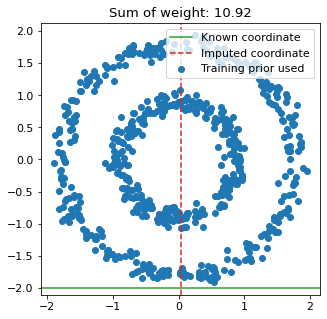

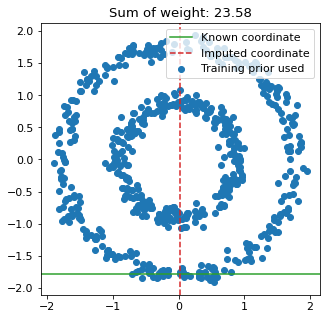

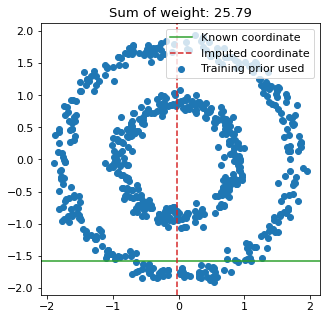

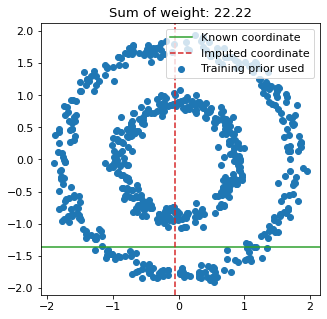

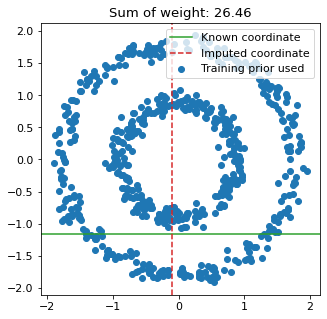

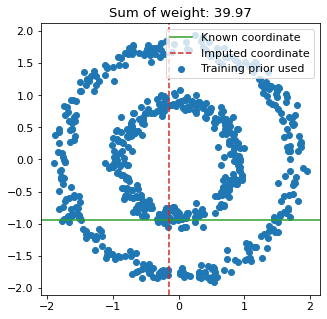

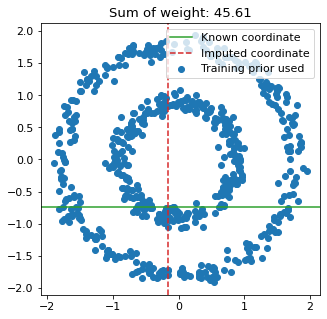

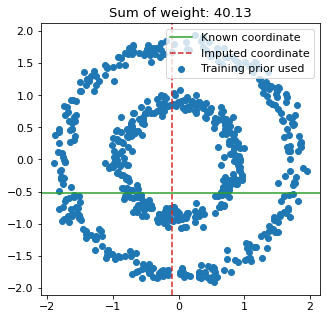

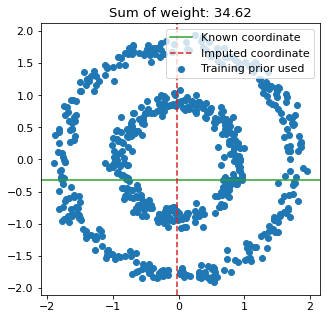

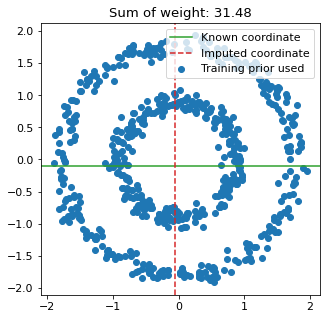

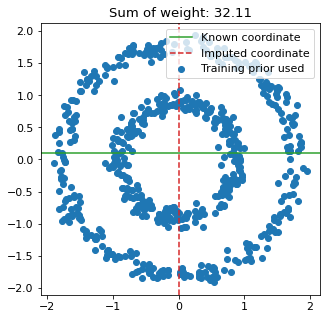

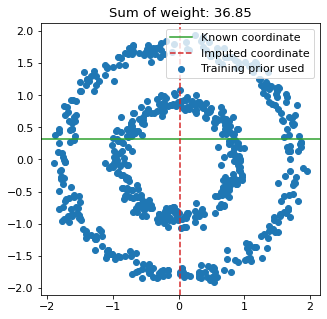

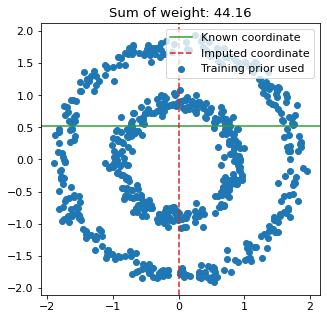

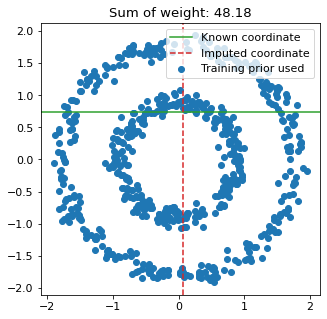

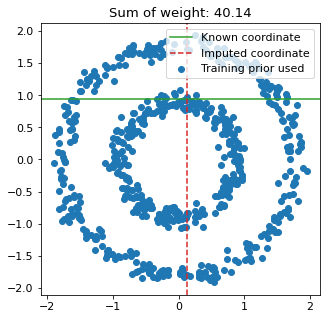

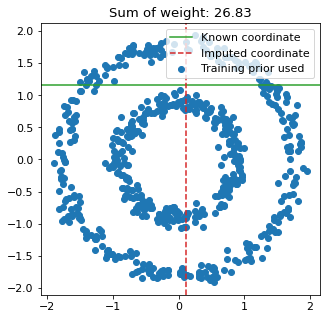

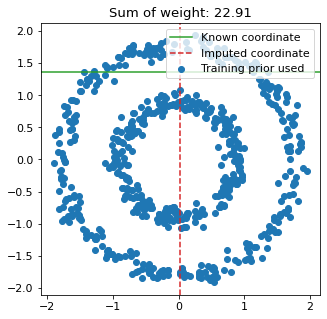

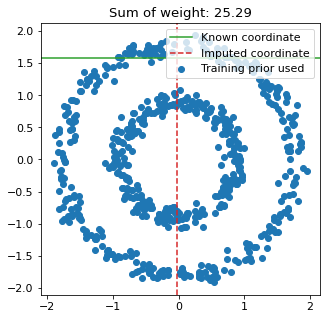

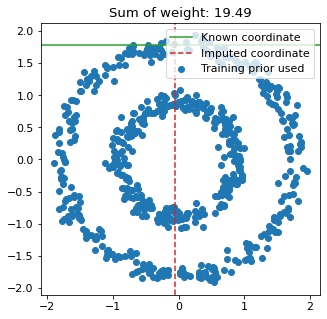

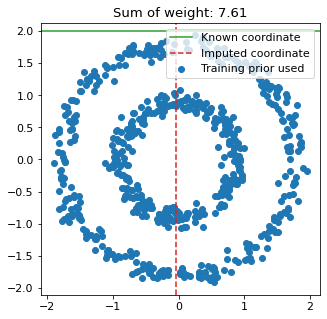

In [73]:



X_i = self.dataset_test.X[5]
w_list = []
a_list = np.linspace(-2, 2, 20)
for a in np.linspace(-2, 2, 20):
    X_i = np.array([np.nan, a])
    from copy import deepcopy
    h=bandwidth
    """
    Contribution of the X_i sample to the estimation of the pdf of X at x. 
    X_prior contains the samples for which there is no missing values, which are used as prior when the contribution of sample with partially missing data is calculated.
    """
    k = X_i.shape[0]  # dimension of the space of samples. 


    # Copy the feature value 
    hat_X_i = deepcopy(X_i)


    # Perform imputation if needed
    coords_missing = np.isnan(X_i)  # unknown coordinates of X_i
    for j in range(k):        
        if coords_missing[j]:  # we don't know the j-th coordinate, we need to impute it

            # We use the term associate to the j-th coordinate for the 
            # rest of the samples in the training set (for which the j-th component is know).
            # The contribution of each term is weighted with the distance to the sample hyperplane.
            hat_X_ij = 0
            Ws = 1e-10  # eps
            for X_p in X_prior:
                w_p = W(X_i, X_p)
                hat_X_ij += w_p * X_p[j]
                Ws += w_p
            hat_X_ij /= Ws

            hat_X_i[j] = hat_X_ij



    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(X_prior[:,0], X_prior[:,1], label='Training prior used')
    if coords_missing[0]:
        ax.axhline(y=X_i[1], color='tab:green', label='Known coordinate')
        ax.axvline(x=hat_X_i[0], color='tab:red', linestyle='--',  label='Imputed coordinate')
    elif coords_missing[1]:
        ax.axvline(x=X_i[0], color='tab:green', label='Known coordinate')
        ax.axhline(y=hat_X_i[1], color='tab:red', linestyle='-.', label='Imputed coordinate')
    ax.set_title("Sum of weight: {:.2f}".format(Ws))
    plt.legend()
    w_list.append(Ws)

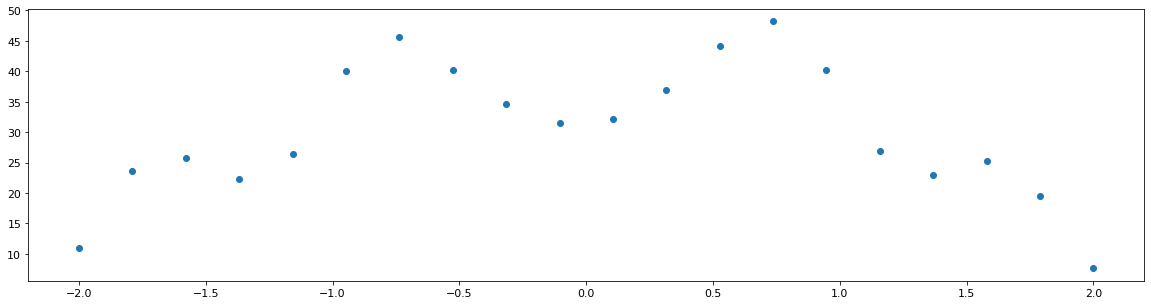

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.scatter(a_list, w_list, label='Training prior used')

(array([ 2.,  1.,  9.,  7.,  7.,  5.,  7.,  7.,  8.,  3.,  8.,  1.,  4.,
         3.,  3.,  1.,  8.,  1.,  2.,  2.,  6.,  5.,  3.,  8.,  7., 11.,
        10.,  7., 10., 12., 12., 12., 10.,  9.,  8., 11.,  8.,  9.,  7.,
         5.,  5.,  8., 13., 12.,  5., 11.,  6.,  6.,  5.,  6.,  7.,  6.,
        10.,  4.,  3.,  5.,  6., 10.,  9.,  8.,  5.,  6.,  6.,  9.,  7.,
         4., 14., 14., 11., 13., 10., 10.,  9.,  9.,  3.,  3.,  5.,  5.,
         3.,  3.,  2.,  4.,  4.,  2.,  9.,  2.,  4.,  4.,  8.,  5.,  4.,
         5.,  8.,  7.,  6.,  3.,  4.,  4.,  1.,  1.]),
 array([-1.90212367, -1.86353119, -1.82493871, -1.78634622, -1.74775374,
        -1.70916126, -1.67056877, -1.63197629, -1.5933838 , -1.55479132,
        -1.51619884, -1.47760635, -1.43901387, -1.40042139, -1.3618289 ,
        -1.32323642, -1.28464393, -1.24605145, -1.20745897, -1.16886648,
        -1.130274  , -1.09168152, -1.05308903, -1.01449655, -0.97590406,
        -0.93731158, -0.8987191 , -0.86012661, -0.82153413, -0.782941

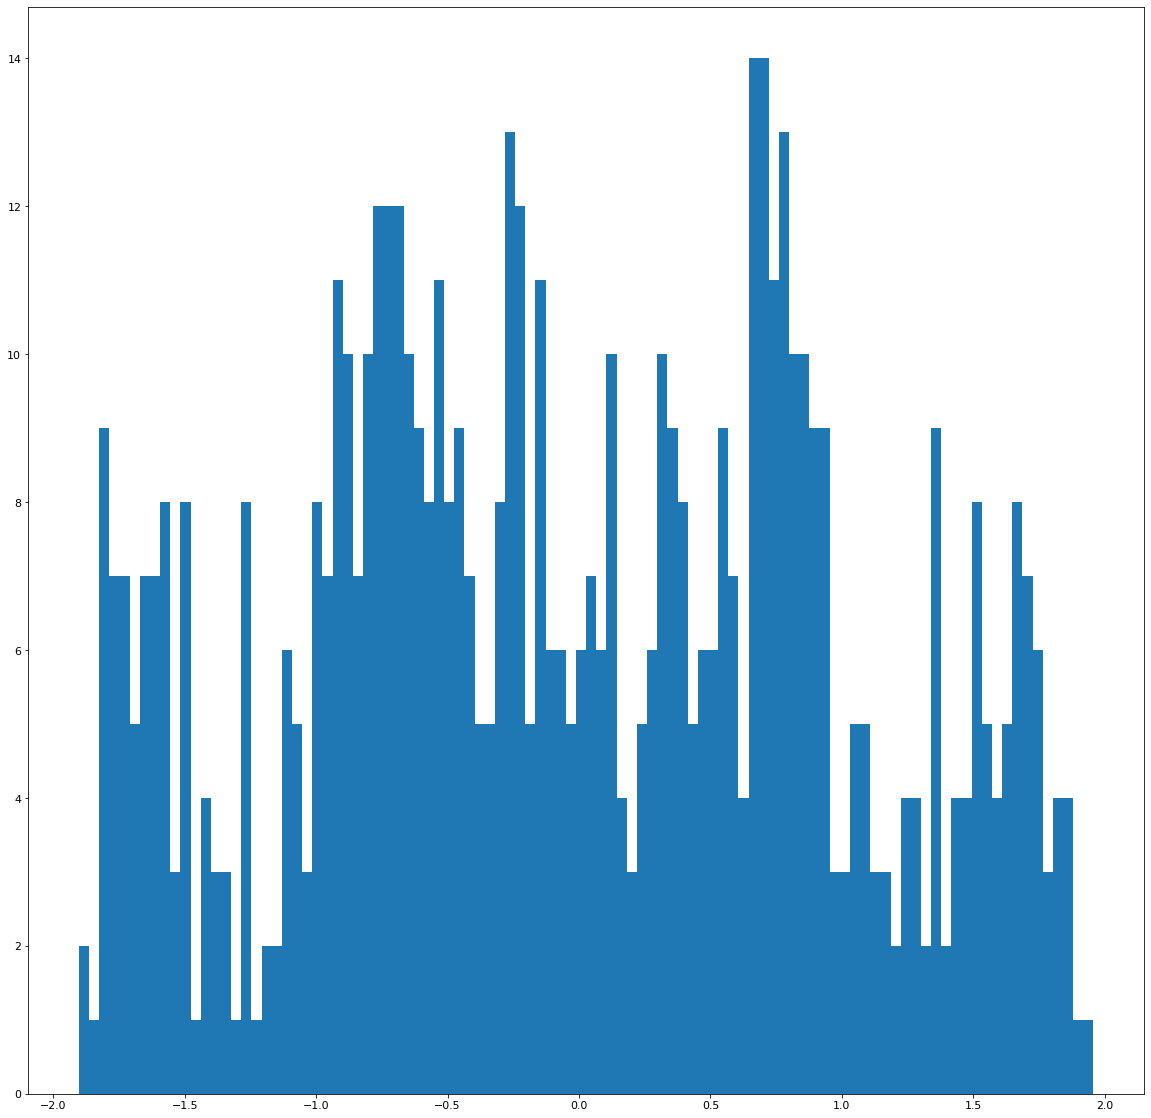

In [80]:
fi(20,20)
plt.hist(X_prior[:,0], bins=100)

In [77]:
X_prior

array([[-1.77376447,  0.10066745],
       [-0.51293983,  0.72030419],
       [ 0.93408859, -0.02222138],
       ...,
       [ 0.88751608, -0.38326858],
       [ 0.4311868 ,  0.73814206],
       [ 0.15760208,  0.78081698]])